In [1]:
import pandas as pd
import numpy as np
import math
import statistics
import datetime as dt
import warnings
import time
import smogn
from matplotlib import pyplot as plt

from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc, integrated_brier_score
from sksurv.ensemble import RandomSurvivalForest, ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis
from sksurv.svm import FastSurvivalSVM
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sksurv.functions import StepFunction
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import eli5
from eli5.sklearn import PermutationImportance
from tqdm import tqdm

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sksurv.preprocessing import OneHotEncoder


In [2]:
#load data
pd.set_option('display.max_columns', None)
df = pd.read_csv('imputed_vent.csv')
#df = df.drop(axis=1, columns=['Unnamed: 0','last_careunit'])

In [3]:
df.head(10)

,Unnamed: 0,temp_first,temp_last,hr_first,hr_last,spo2_first,spo2_last,rr_first,rr_last,sbp_first,sbp_last,dbp_first,dbp_last,meanbp_first,meanbp_last,cardiac_index_first,cardiac_index_last,pt_first,pt_last,ptt_first,ptt_last,inr_first,inr_last,hb_first,hb_last,wcc_first,wcc_last,chloride_first,chloride_last,potassium_first,potassium_last,creatinine_first,creatinine_last,free_calcium_first,free_calcium_last,sodium_first,sodium_last,bicarb_first,bicarb_last,bun_first,bun_last,glucose_first,glucose_last,lactate_last,aki_first,aki_last,po2_first,po2_last,pco2_first,pco2_last,baseexcess_first,baseexcess_last,ph_first,ph_last,fio2_first,fio2_last,insulin_first,insulin_last,plt_first,plt_last,dtoutput_first,dtoutput_last,padp_first,padp_last,tvobs_first,tvobs_last,tvobs_mean,tvobs_max,tvobs_min,tvset_first,tvset_last,tvset_mean,tvset_max,tvset_min,minute_volume_first,minute_volume_last,minute_volume_mean,minute_volume_max,minute_volume_min,plat_first,plat_last,plat_mean,plat_max,plat_min,peep_first,peep_last,peep_mean,peep_max,peep_min,fio2_mean,fio2_max,fio2_min,rrset_first,rrset_last,rrset_mean,rrset_max,rrset_min,rrtotal_first,rrtotal_last,rrtotal_mean,rrtotal_max,rrtotal_min,rrspont_first,rrspont_last,rrspont_mean,rrspont_max,rrspont_min,inotropes_duration,inotropes_bool,inotropes_count,infection_first,infection_vent,age,gender,ethnicity,marital_status,insurance,language,aortic,mitral,tricuspid,pulmonary,cabg,multi_valve,cabg_valve,weight,height,bmi,sofa,reintubation,liver_severe,liver_mild,rheum,cvd,aids,ckd,copd,arrhythmia,pud,smoking,pvd,paraplegia,ccf,met_ca,t2dm,t1dm,malig,mi,dementia,first_careunit,last_careunit,admission_location,admission_type,hospital_expire_flag,diab_un,diab_cc,duration1,prbc_sum,prbc_bool,ffp_sum,ffp_bool,cryo_sum,cryo_bool,plts_sum,plts_bool,icu_stay_duration,admittime,dischtime,intime,outtime,ext_time,los,icustay_seq,deathtime,first_readmission,readmissions,hadm_id,subject_id,int_time1,ext_time1,int_time2,ext_time2,duration2
0,0,38.000000,38.000000,100.0,100.0,100.0,100.0,21.0,21.0,100.0,100.0,51.0,51.0,66.0,66.0,3.19502,3.19502,14.6,14.5,31.2,41.9,1.3,1.3,9.1,9.9,17.2,21.0,105.0,109.0,4.7,4.0,0.6,0.5,1.16,1.27,138.0,138.0,27.0,25.0,11.0,8.0,147.0,120.0,1.5,0.0,0.0,-2.0,0.0,37.0,51.0,-2.0,0.0,7.38,7.34,1.0,0.5,0.0,313.0,309.0,356.0,0.0,0.0,20.0,20.0,400.0,460.0,470.000000,550.0,400.0,520.0,520.0,510.000000,520.00,510.0,6.6,11.4,7.933333,11.4,5.8,17.8,18.0,18.0,18.6,17.700001,5.0,5.0,5.000000,5.0,5.0,0.640000,1.0,0.5,16.0,16.0,16.666667,17.0,16.0,16.0,16.0,15.666667,16.0,15.0,1.0,0.0,0.000000,0.0,0.0,0.00,1.0,2.0,0,0,19.0,F,white,SINGLE,Private,ENGL,0,1,0,0,0,0,0,115.4,170.18,39.846371,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,CSRU,CSRU,EMERGENCY ROOM,EMERGENCY,0,0,0,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92540.0,2148-12-15 00:19:00,2149-01-04 15:45:00,2148-12-23 13:00:34,2148-12-24 16:42:20,2148-12-23 18:00:00,1.1540,2,NaN,NaN,NaN,132385,28772,2148-12-23 15:00:00,2148-12-23 18:00:00,NaN,NaN,NaN
1,1,36.599998,36.500000,106.0,104.0,95.0,95.0,23.0,16.0,115.0,114.0,72.0,71.0,85.0,85.0,4.13613,4.18848,16.5,19.9,31.9,47.8,1.5,1.8,9.6,8.6,18.1,34.7,104.0,109.0,4.6,3.9,0.7,0.6,1.00,1.13,137.0,139.0,24.0,24.0,15.0,15.0,96.0,121.0,1.4,0.0,0.0,0.0,0.0,37.0,34.0,0.0,0.0,7.44,7.43,1.0,0.4,317.0,242.0,241.0,222.0,40.0,20.0,21.0,19.0,661.0,567.0,678.000000,806.0,567.0,510.0,450.0,475.000000,500.00,450.0,7.7,14.0,10.850000,14.0,7.7,18.0,18.0,18.0,18.0,18.000000,5.0,5.0,5.000000,5.0,5.0,0.600000,1.0,0.4,14.0,15.0,15.500000,18.0,14.0,20.0,16.0,16.000000,16.0,16.0,0.0,11.0,4.666667,11.0,0.0,2.50,1.0,2.0,0,0,22.0,M,white,SINGLE,Private,PORT,0,0,0,0,0,1,0,71.1,190.50,19.592039,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,CSRU,CSRU,EMERGENCY ROOM,EMERGENCY,0,0,0,2.683333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107383.0,2166-09-24 20:15:00,2166-10-20 13:30:00,2166-10-06 09:41:05,2166-10-07 17:19:43,2166-10-06 14:11:00,1.3185,2,NaN,NaN,NaN,109148,16927,2166-10-06 11:30:00,2166-10-06 14:11:00,NaN,NaN,NaN
2,2,37.200001,37.200001,90.0

## 1: Post-pre-processing

#### 1.1: Variable grouping

In [4]:
# variables for analysis
categorical = ['ethnicity', 
              'marital_status',
              'language',
              'admission_location',
              'gender',
              'insurance',
              'first_careunit',
              'admission_type']
proceduretype=['aortic','mitral','tricuspid','pulmonary','cabg','multi_valve','cabg_valve']
ptParams = ['weight', 'height', 'bmi', 'sofa', 'age','inotropes_duration','inotropes_count','prbc_sum','cryo_sum','plts_sum','ffp_sum']
ptParams_first = ['weight', 'height', 'bmi', 'sofa', 'age','prbc_sum','cryo_sum','plts_sum','ffp_sum']
boolFields = ['reintubation', 'liver_severe', 'liver_mild', 'rheum', 'cvd', 'aids', 'ckd', 'copd', 'arrhythmia', 'pud', 'smoking', 'pvd', 'paraplegia', 
              'ccf', 'met_ca', 't2dm', 't1dm', 'malig', 'mi', 'dementia', 'hospital_expire_flag', 'diab_un', 'diab_cc','infection_vent','inotropes_bool',
              'prbc_bool','cryo_bool','plts_bool','ffp_bool']
ptinfo = ['hadm_id', 'subject_id']
ptTimes = ['int_time1','ext_time1','int_time2','ext_time2','admittime', 'dischtime', 'deathtime','intime', 'outtime', 'ext_time', 'icustay_seq']
tsColumns_first = [i for i in df.columns if '_first' in i]
tsColumns_last = [i for i in df.columns if '_last' in i]
tsColumns_others = [i for i in df.columns if '_max' in i or '_min' in i or '_mean' in i]

inputs = [*categorical , *proceduretype , *tsColumns_first, *tsColumns_last, *ptParams_first , *[i for i in boolFields if i != 'reintubation' and i != 'hospital_expire_flag' and i != 'infection_vent']]
inputs_all = [*categorical , *proceduretype , *tsColumns_first , *tsColumns_others, *ptParams , *[i for i in boolFields if i != 'reintubation' and i != 'hospital_expire_flag']]
outcomes = ['reintubation','hospital_expire_flag','los','duration1','duration2','icu_stay_duration']

print([i for i in df.columns if i not in categorical + proceduretype + tsColumns_first + tsColumns_last + tsColumns_others + ptParams + boolFields + ptinfo + ptTimes + outcomes])
print([i for i in df.columns if i not in inputs + outcomes + ptTimes + tsColumns_others + tsColumns_last])


['Unnamed: 0', 'last_careunit', 'first_readmission', 'readmissions']
['Unnamed: 0', 'inotropes_duration', 'inotropes_count', 'infection_vent', 'last_careunit', 'first_readmission', 'readmissions', 'hadm_id', 'subject_id']


In [5]:
# change categorical to category type
for col in categorical:
    df[col] = df[col].astype('category')

In [6]:
# create censor column for death before extubation
censor = []
for i in range(len(df)):
    if df['deathtime'][i] is np.NaN:
        censor.append(True)
        continue
    deathtime = dt.datetime.strptime(df['deathtime'][i], '%Y-%m-%d %H:%M:%S')
    try: 
        exttime = dt.datetime.strptime(df['ext_time1'][i], '%Y-%m-%d %H:%M:%S')
    except:
        censor.append(True)
        continue
    if deathtime >= exttime:
        censor.append(True)
    else:
        censor.append(False)
censored = []
for i in range(len(censor)):
    if censor[i] == False:
        censored.append(i)
print('Number censored: '+str(len(censored)))
print(censored)

df['censor'] = censor

Number censored: 5
[3151, 3454, 3728, 4530, 6103]


In [7]:
df[inputs]

,ethnicity,marital_status,language,admission_location,gender,insurance,first_careunit,admission_type,aortic,mitral,tricuspid,pulmonary,cabg,multi_valve,cabg_valve,temp_first,hr_first,spo2_first,rr_first,sbp_first,dbp_first,meanbp_first,cardiac_index_first,pt_first,ptt_first,inr_first,hb_first,wcc_first,chloride_first,potassium_first,creatinine_first,free_calcium_first,sodium_first,bicarb_first,bun_first,glucose_first,aki_first,po2_first,pco2_first,baseexcess_first,ph_first,fio2_first,insulin_first,plt_first,dtoutput_first,padp_first,tvobs_first,tvset_first,minute_volume_first,plat_first,peep_first,rrset_first,rrtotal_first,rrspont_first,infection_first,temp_last,hr_last,spo2_last,rr_last,sbp_last,dbp_last,meanbp_last,cardiac_index_last,pt_last,ptt_last,inr_last,hb_last,wcc_last,chloride_last,potassium_last,creatinine_last,free_calcium_last,sodium_last,bicarb_last,bun_last,glucose_last,lactate_last,aki_last,po2_last,pco2_last,baseexcess_last,ph_last,fio2_last,insulin_last,plt_last,dtoutput_last,padp_last,tvobs_last,tvset_last,minute_volume_last,plat_last,peep_last,rrset_last,rrtotal_last,rrspont_last,weight,height,bmi,sofa,age,prbc_sum,cryo_sum,plts_sum,ffp_sum,liver_severe,liver_mild,rheum,cvd,aids,ckd,copd,arrhythmia,pud,smoking,pvd,paraplegia,ccf,met_ca,t2dm,t1dm,malig,mi,dementia,diab_un,diab_cc,inotropes_bool,prbc_bool,cryo_bool,plts_bool,ffp_bool
0,white,SINGLE,ENGL,EMERGENCY ROOM,F,Private,CSRU,EMERGENCY,0,1,0,0,0,0,0,38.000000,100.0,100.0,21.0,100.0,51.0,66.0,3.19502,14.6,31.2,1.3,9.1,17.2,105.0,4.7,0.6,1.16,138.0,27.0,11.0,147.0,0.0,-2.0,37.0,-2.0,7.38,1.0,0.000000,309.0,0.0,20.0,400.0,520.0,6.6,17.800000,5.0,16.0,16.0,1.0,0,38.000000,100.0,100.0,21.0,100.0,51.0,66.0,3.19502,14.5,41.9,1.3,9.9,21.0,109.0,4.0,0.5,1.27,138.0,25.0,8.0,120.0,1.5,0.0,0.0,51.0,0.0,7.34,0.5,313.000000,356.0,0.0,20.0,460.0,520.0,11.4,18.0,5.0,16.0,16.0,0.0,115.40,170.18,39.846371,2,19.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
1,white,SINGLE,PORT,EMERGENCY ROOM,M,Private,CSRU,EMERGENCY,0,0,0,0,0,1,0,36.599998,106.0,95.0,23.0,115.0,72.0,85.0,4.13613,16.5,31.9,1.5,9.6,18.1,104.0,4.6,0.7,1.00,137.0,24.0,15.0,96.0,0.0,0.0,37.0,0.0,7.44,1.0,317.000000,241.0,40.0,21.0,661.0,510.0,7.7,18.000000,5.0,14.0,20.0,0.0,0,36.500000,104.0,95.0,16.0,114.0,71.0,85.0,4.18848,19.9,47.8,1.8,8.6,34.7,109.0,3.9,0.6,1.13,139.0,24.0,15.0,121.0,1.4,0.0,0.0,34.0,0.0,7.43,0.4,242.000000,222.0,20.0,19.0,567.0,450.0,14.0,18.0,5.0,15.0,16.0,11.0,71.10,190.50,19.592039,5,22.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
2,asian,SINGLE,PORT,PHYSICIAN REFERRAL,M,Private,CSRU,ELECTIVE,0,1,0,0,0,0,0,37.200001,90.0,100.0,17.0,112.0,58.0,73.0,3.46154,14.5,33.5,1.3,9.0,9.2,99.0,4.6,0.5,1.07,133.0,27.0,7.0,134.0,0.0,-5.0,41.0,-5.0,7.30,1.0,180.000000,124.0,40.0,15.0,570.0,450.0,6.9,15.000000,5.0,15.0,15.0,8.0,0,37.200001,90.0,100.0,17.0,112.0,58.0,73.0,3.46154,16.6,43.3,1.5,10.0,6.9,111.0,4.0,0.5,1.00,143.0,24.0,7.0,136.0,1.5,0.0,-2.0,47.0,-2.0,7.31,0.4,285.000000,116.0,40.0,15.0,483.0,400.0,10.4,16.0,5.0,17.0,16.0,12.0,66.00,182.88,19.733836,7,22.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
3,white,SINGLE,ENGL,PHYSICIAN REFERRAL,M,Private,CSRU,EMERGENCY,1,0,0,0,0,0,0,36.599998,108.0,100.0,12.0,100.0,60.0,74.0,3.26633,12.4,28.5,1.0,10.8,18.5,106.0,4.2,0.6,1.08,141.0,27.0,10.0,101.0,0.0,3.0,55.0,3.0,7.36,1.0,0.000000,296.0,50.0,6.0,787.0,450.0,8.5,22.000000,5.0,16.0,15.0,6.0,1,36.599998,110.0,100.0,15.0,96.0,62.0,73.0,3.06533,14.8,34.9,1.4,10.5,21.8,107.0,3.5,0.5,1.24,138.0,24.0,11.0,113.0,1.2,0.0,2.0,44.0,2.0,7.40,0.4,362.000000,227.0,5.0,8.0,725.0,480.0,9.1,21.0,5.0,14.0,18.0,0.0,78.00,182.88,23.321806,3,23.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
4,white,SINGLE,CAPE,PHYSICIAN REFERRAL,F,Private,CSRU,ELECTIVE,0,1,0,0,0,0,0,36.799999,86.0,100.0,16.0,95.0,54.0,70.0,2.41753,18.3,49.2,1.7,11.5,21.6,107.0,4.3,0.8,1.22,137.0,22.0,12.0,204.0,2.0,-1

#### 1.2: !!X, Xt, y!!

In [8]:
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)
Xt = Xt.drop(['first_careunit=Neuro Inter','admission_type=DIRECT OBSERVATION'],axis=1)
Xt

,ethnicity=black,ethnicity=hispanic,ethnicity=native,ethnicity=other,ethnicity=white,marital_status=MARRIED,marital_status=SEPARATED,marital_status=SINGLE,marital_status=WIDOWED,language=*GUJ,language=*LEB,language=ALBA,language=AMER,language=ARAB,language=CAMB,language=CANT,language=CAPE,language=ENGL,language=ETHI,language=GERM,language=GREE,language=HAIT,language=HIND,language=ITAL,language=KORE,language=MAND,language=PERS,language=POLI,language=PORT,language=PTUN,language=RUSS,language=SPAN,language=THAI,language=TURK,language=URDU,language=VIET,admission_location=CLINIC REFERRAL/PREMATURE,admission_location=EMERGENCY ROOM,admission_location=INTERNAL TRANSFER TO OR FROM PSYCH,admission_location=PACU,admission_location=PHYSICIAN REFERRAL,admission_location=PROCEDURE SITE,admission_location=TRANSFER FROM HOSPITAL,admission_location=TRANSFER FROM SKILLED NURSING FACILITY,admission_location=WALK-IN/SELF REFERRAL,gender=M,insurance=Medicaid,insurance=Medicare,insurance=Other,insurance=Private,insurance=Self Pay,first_careunit=CSRU,first_careunit=CVICU,first_careunit=MICU,first_careunit=MICU/SICU,first_careunit=Neuro SICU,first_careunit=SICU,first_careunit=TSICU,admission_type=ELECTIVE,admission_type=EMERGENCY,admission_type=EW EMER.,admission_type=OBSERVATION ADMIT,admission_type=SURGICAL SAME DAY ADMISSION,admission_type=URGENT,aortic,mitral,tricuspid,pulmonary,cabg,multi_valve,cabg_valve,temp_first,hr_first,spo2_first,rr_first,sbp_first,dbp_first,meanbp_first,cardiac_index_first,pt_first,ptt_first,inr_first,hb_first,wcc_first,chloride_first,potassium_first,creatinine_first,free_calcium_first,sodium_first,bicarb_first,bun_first,glucose_first,aki_first,po2_first,pco2_first,baseexcess_first,ph_first,fio2_first,insulin_first,plt_first,dtoutput_first,padp_first,tvobs_first,tvset_first,minute_volume_first,plat_first,peep_first,rrset_first,rrtotal_first,rrspont_first,infection_first,temp_last,hr_last,spo2_last,rr_last,sbp_last,dbp_last,meanbp_last,cardiac_index_last,pt_last,ptt_last,inr_last,hb_last,wcc_last,chloride_last,potassium_last,creatinine_last,free_calcium_last,sodium_last,bicarb_last,bun_last,glucose_last,lactate_last,aki_last,po2_last,pco2_last,baseexcess_last,ph_last,fio2_last,insulin_last,plt_last,dtoutput_last,padp_last,tvobs_last,tvset_last,minute_volume_last,plat_last,peep_last,rrset_last,rrtotal_last,rrspont_last,weight,height,bmi,sofa,age,prbc_sum,cryo_sum,plts_sum,ffp_sum,liver_severe,liver_mild,rheum,cvd,aids,ckd,copd,arrhythmia,pud,smoking,pvd,paraplegia,ccf,met_ca,t2dm,t1dm,malig,mi,dementia,diab_un,diab_cc,inotropes_bool,prbc_bool,cryo_bool,plts_bool,ffp_bool
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,38.000000,100.0,100.0,21.0,100.0,51.0,66.0,3.19502,14.6,31.2,1.3,9.1,17.2,105.0,4.7,0.6,1.16,138.0,27.0,11.0,147.0,0.0,-2.0,37.0,-2.0,7.38,1.0,0.000000,309.0,0.0,20.0,400.0,520.0,6.6,17.800000,5.0,16.0,16.0,1.0,0,38.000000,100.0,100.0,21.0,100.0,51.0,66.0,3.19502,14.5,41.9,1.3,9.9,21.0,109.0,4.0,0.5,1.27,138.0,25.0,8.0,120.0,1.5,0.0,0.0,51.0,0.0,7.34,0.5,313.000000,356.0,0.0,20.0,460.0,520.0,11.4,18.0,5.0,16.0,16.0,0.0,115.40,170.18,39.846371,2,19.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,36.599998,106.0,95.0,23.0,115.0,72.0,85.0,4.13613,16.5,31.9,1.5,9.6,18.1,104.0,4.6,0.7,1.00,137.0,24.0,15.0,96.0,0.0,0.0,37.0,0.0,7.44,1.0,317.000000,241.0,40.0,21.0,661.0,510.0,7.7,18.000000,5.0,14.0,20.0,0.0,0,36.500000,104.0,95.0,16.0,114.0,71.0,85.0,4.18848,19.9,47.8,1.8,8.6,34.7,109.0,3.9,0.6,1.

In [9]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)
Xt = Xt.drop(['first_careunit=Neuro Inter','admission_type=DIRECT OBSERVATION'],axis=1)
Xt_columns = list(Xt.columns)
Xt_scaled = StandardScaler().fit_transform(Xt, y=None)
Xt_scaled = pd.DataFrame(data=Xt_scaled,columns=Xt_columns)
Scaler = StandardScaler().fit(Xt,y=None)

df['duration1'] = df['duration1'].replace({0.0: 1})
y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] = df['duration1']
y

array([( True, 3.        ), ( True, 2.68333333), ( True, 3.25      ), ...,
       ( True, 9.        ), ( True, 3.        ), ( True, 6.        )],
      dtype=[('Censor', '?'), ('Survival', '<f8')])

#### 1.3: Plotting y

In [10]:
pd.DataFrame(y).dropna()

,Censor,Survival
0,True,3.000000
1,True,2.683333
2,True,3.250000
3,True,8.500000
4,True,4.666667
...,...,...
10425,True,4.000000
10426,True,14.000000
10427,True,9.000000
10428,True,3.000000


In [501]:
y_1['Survival'][y_1['Survival']>48].count()

579

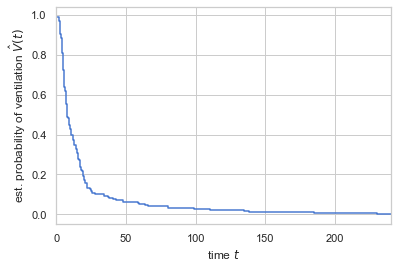

In [493]:
# view the data
time, survival_prob = kaplan_meier_estimator(y["Censor"], y["Survival"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of ventilation $\hat{V}(t)$")
plt.xlabel("time $t$")
plt.xlim([0, 240])
plt.savefig('surv_curve_fig1.png', dpi=600)

(array([ 802., 3111., 2044.,  939.,  684., 1103.,  650.,  203.,   59.,
          83.,  118.]),
 array([ 0,  3,  6,  9, 12, 15, 20, 25, 30, 35, 40, 45]),
 <BarContainer object of 11 artists>)

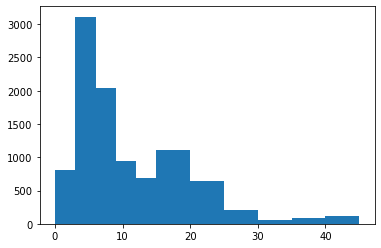

In [13]:
plt.hist(y["Survival"],bins=[0,3,6,9,12,15,20,25,30,*list(range(35,50,5))],range=(0,50))

## 2: Survival Analysis

### 2.1: Cox elastic net

In [82]:
coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.0001, max_iter=100)
)
warnings.simplefilter("ignore", ConvergenceWarning)
coxnet_pipe.fit(Xt_scaled, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.0001, l1_ratio=0.9,
                                        max_iter=100))])

In [87]:
estimated_alphas

array([0.42445078, 0.38674374, 0.35238649, 0.32108145, 0.29255746,
       0.26656746, 0.24288634, 0.22130899, 0.20164851, 0.18373461,
       0.16741213, 0.1525397 , 0.13898849, 0.12664114, 0.11539069,
       0.1051397 , 0.09579938, 0.08728882, 0.07953433, 0.07246872,
       0.06603079, 0.0601648 , 0.05481993, 0.04994987, 0.04551247,
       0.04146926, 0.03778525, 0.03442851, 0.03136998, 0.02858315,
       0.02604391, 0.02373024, 0.02162211, 0.01970126, 0.01795105,
       0.01635633, 0.01490328, 0.01357931, 0.01237297, 0.01127379,
       0.01027225, 0.00935969, 0.00852821, 0.00777058, 0.00708027,
       0.00645127, 0.00587816, 0.00535596, 0.00488015, 0.00444661,
       0.00405159, 0.00369166, 0.0033637 , 0.00306488, 0.0027926 ,
       0.00254452, 0.00231847, 0.0021125 , 0.00192483, 0.00175384,
       0.00159803, 0.00145607, 0.00132671, 0.00120885, 0.00110146,
       0.00100361, 0.00091445, 0.00083321, 0.00075919, 0.00069175,
       0.0006303 , 0.0005743 ])

In [86]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis()),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(Xt_scaled, y)

cv_results = pd.DataFrame(gcv.cv_results_)

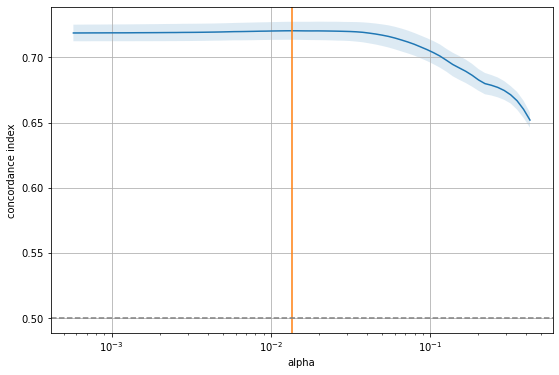

In [104]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [105]:
best_alpha = gcv.best_params_["coxnetsurvivalanalysis__alphas"][0]
print(best_alpha)

0.013579314239812288


Number of non-zero coefficients: 113


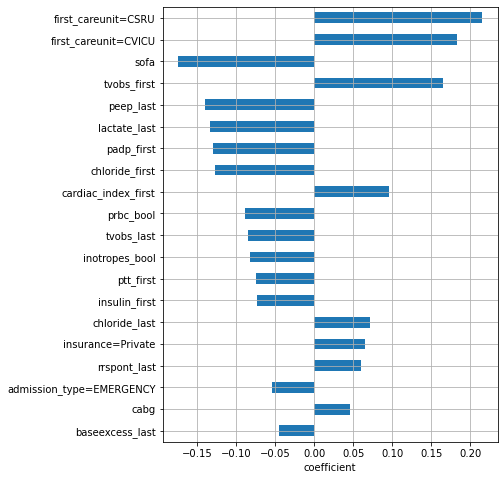

In [106]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=Xt.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order[-20:]].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

### 2.2 Hyperparameter tuning

In [14]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)
Xt = Xt.drop(['first_careunit=Neuro Inter','admission_type=DIRECT OBSERVATION'],axis=1)
Xt_columns = list(Xt.columns)
Xt_scaled = StandardScaler().fit_transform(Xt, y=None)
Xt_scaled_1 = pd.DataFrame(data=Xt_scaled,columns=Xt_columns)

df['duration1'] = df['duration1'].replace({0.0: 1})
y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] = df['duration1']
y_1 = pd.DataFrame(y)

In [15]:
def y_to_np(y):
    y1 = np.zeros(len(y), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})
    y1['Censor'] = y['Censor']
    y1['Survival'] = y['Survival']
    return y1

In [16]:
Xt_scaled, X_final_test, y1, y_final_test = train_test_split(
    Xt_scaled_1, y_1, test_size=0.2, stratify=y_1["Censor"], random_state=42)

y = y_to_np(y1)

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
# https://github.com/nickkunz/smogn
import smogn  # try using smogn package for oversampling regression

# initialising random seed for smoter
import random

random_seed = 42
random_state = random.Random(random_seed)

# generic classes for use in pipelines below

class ReturnXY(BaseEstimator, TransformerMixin):
    def __init__(self, ycolnames):
        self.ycolnames = ycolnames
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        y = X[self.ycolnames]
        X = X.drop(columns = self.ycolnames)
        return X, y

class SMOTER(BaseEstimator, TransformerMixin):
    def __init__(self, yname):
        self.yname = yname
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        resampled = smogn.smoter(
            ## main arguments
            data = X,                 ## pandas dataframe
            y = self.yname,          ## string ('header name')
            k = 9,                    ## positive integer (k < n)
            samp_method = 'extreme',  ## string ('balance' or 'extreme')

            ## phi relevance arguments
            rel_thres = 0.80,         ## positive real number (0 < R < 1)
            rel_method = 'auto',      ## string ('auto' or 'manual')
            rel_xtrm_type = 'high',   ## string ('low' or 'both' or 'high')
            rel_coef = 2.25           ## positive real number (0 < R)
            )   
        return resampled

class SurvivalModels(BaseEstimator):
    def __init__(self, model_type):
        self.model_type = model_type
        
    def fit(self, X, y):
        if self.model_type == 'rsf':
            self.model = RandomSurvivalForest(n_estimators=100)
        elif self.model_type == 'gbsa':
            self.model = GradientBoostingSurvivalAnalysis(n_estimators=100)
        elif self.model_type == 'svm':
            self.model = FastSurvivalSVM(fit_intercept=False)
        elif self.model_type == 'coxnet':
            self.model = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.0001, max_iter=100)
        else:
            raise ValueError('Invalid model type')
        
        self.model.fit(X, y)
        
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_survival_function(self, X):
        return self.model.predict_survival_function(X)

Xt_scaled

,ethnicity=black,ethnicity=hispanic,ethnicity=native,ethnicity=other,ethnicity=white,marital_status=MARRIED,marital_status=SEPARATED,marital_status=SINGLE,marital_status=WIDOWED,language=*GUJ,language=*LEB,language=ALBA,language=AMER,language=ARAB,language=CAMB,language=CANT,language=CAPE,language=ENGL,language=ETHI,language=GERM,language=GREE,language=HAIT,language=HIND,language=ITAL,language=KORE,language=MAND,language=PERS,language=POLI,language=PORT,language=PTUN,language=RUSS,language=SPAN,language=THAI,language=TURK,language=URDU,language=VIET,admission_location=CLINIC REFERRAL/PREMATURE,admission_location=EMERGENCY ROOM,admission_location=INTERNAL TRANSFER TO OR FROM PSYCH,admission_location=PACU,admission_location=PHYSICIAN REFERRAL,admission_location=PROCEDURE SITE,admission_location=TRANSFER FROM HOSPITAL,admission_location=TRANSFER FROM SKILLED NURSING FACILITY,admission_location=WALK-IN/SELF REFERRAL,gender=M,insurance=Medicaid,insurance=Medicare,insurance=Other,insurance=Private,insurance=Self Pay,first_careunit=CSRU,first_careunit=CVICU,first_careunit=MICU,first_careunit=MICU/SICU,first_careunit=Neuro SICU,first_careunit=SICU,first_careunit=TSICU,admission_type=ELECTIVE,admission_type=EMERGENCY,admission_type=EW EMER.,admission_type=OBSERVATION ADMIT,admission_type=SURGICAL SAME DAY ADMISSION,admission_type=URGENT,aortic,mitral,tricuspid,pulmonary,cabg,multi_valve,cabg_valve,temp_first,hr_first,spo2_first,rr_first,sbp_first,dbp_first,meanbp_first,cardiac_index_first,pt_first,ptt_first,inr_first,hb_first,wcc_first,chloride_first,potassium_first,creatinine_first,free_calcium_first,sodium_first,bicarb_first,bun_first,glucose_first,aki_first,po2_first,pco2_first,baseexcess_first,ph_first,fio2_first,insulin_first,plt_first,dtoutput_first,padp_first,tvobs_first,tvset_first,minute_volume_first,plat_first,peep_first,rrset_first,rrtotal_first,rrspont_first,infection_first,temp_last,hr_last,spo2_last,rr_last,sbp_last,dbp_last,meanbp_last,cardiac_index_last,pt_last,ptt_last,inr_last,hb_last,wcc_last,chloride_last,potassium_last,creatinine_last,free_calcium_last,sodium_last,bicarb_last,bun_last,glucose_last,lactate_last,aki_last,po2_last,pco2_last,baseexcess_last,ph_last,fio2_last,insulin_last,plt_last,dtoutput_last,padp_last,tvobs_last,tvset_last,minute_volume_last,plat_last,peep_last,rrset_last,rrtotal_last,rrspont_last,weight,height,bmi,sofa,age,prbc_sum,cryo_sum,plts_sum,ffp_sum,liver_severe,liver_mild,rheum,cvd,aids,ckd,copd,arrhythmia,pud,smoking,pvd,paraplegia,ccf,met_ca,t2dm,t1dm,malig,mi,dementia,diab_un,diab_cc,inotropes_bool,prbc_bool,cryo_bool,plts_bool,ffp_bool
2006,-0.203563,-0.186889,-0.062821,-0.224394,0.427404,0.722315,-0.071466,-0.429911,-0.364464,-0.072809,-0.102289,-0.053709,-0.041579,-0.058026,-0.096383,-0.128336,-0.157031,-1.659669,-0.027706,-0.049017,8.511798,-0.087917,-0.085105,-0.118736,-0.052803,-0.055475,-0.10181,-0.073472,-0.168212,-0.162086,-0.146108,-0.177047,-0.076065,-0.049017,-0.050945,-0.063586,-0.208619,-0.308801,-0.009792,-0.056338,-1.169285,-0.104186,1.614466,-0.0219,-0.04272,0.640932,-0.198921,-0.947311,-0.702738,2.385411,-0.03795,1.366944,-1.203477,-0.075425,-0.019587,-0.009792,-0.044916,-0.030979,-0.592188,1.949878,-0.213820,-0.181322,-0.582000,-0.471653,-0.460222,-0.298061,-0.065088,-0.029388,0.897112,-0.179623,-0.425362,0.811073,0.720556,-1.121554,-0.278906,0.302892,0.569863,0.286286,0.019081,0.079723,0.282857,-0.233985,1.987265,-0.289797,1.137328,-0.181329,-0.076009,-0.623745,-0.369491,-0.135977,-0.171629,1.275837,-0.222958,-1.150799,-1.292942,-1.031380,0.426406,-1.303282,1.766427,-0.859814,-0.422330,-1.322574,0.962968,-1.163458,-0.527532,-0.779329,-0.295788,-0.778871,-0.590094,0.859517,-0.136944,0.448625,0.325538,0.118775,-0.254149,3.100329,1.538076,2.370136,0.136407,0.485116,-0.171589,0.715897,2.251141,-0.153075,1.807913,0.750486,0.042378,0.855831,0.944402,-0.491445,-0.427647,0.552838,-0.165643,-0.20982,-1.002441,0.760266,0.240966,-0.442493,-1.140340,0.638888,-0.672953,-0.670369,-

In [200]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# Instantiate the classes
returnXY = ReturnXY(ycolnames = ["Censor", "Survival"])
smoter = SMOTER(yname = "Survival")

# Define the 5-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialise scoring
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Censor"], y["Survival"], prediction)
    return result[0]

# Create the pipeline
pipe = Pipeline([
    ('returnXY', returnXY),
    ('smoter', smoter),])

In [201]:
# Initialise trainDict and testDict
trainDict = {}
testDict = {}

# Get and store oversampled CV train and test datasets
for i, (train_index, test_index) in enumerate(cv.split(Xt_scaled, y)):
    X_train, testDict['X'+str(i)] = Xt_scaled.iloc[train_index], Xt_scaled.iloc[test_index]
    y_train, testDict['y'+str(i)] = y1.iloc[train_index], y1.iloc[test_index]
    # Get the oversampled data for the training set only
    train_data = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
    train_smogn = smogn.smoter(
            ## main arguments
            data = train_data,          ## pandas dataframe
            y = 'Survival',          ## string ('header name')
            k = 9,                    ## positive integer (k < n)
            samp_method = 'extreme',  ## string ('balance' or 'extreme')

            ## phi relevance arguments
            rel_thres = 0.80,         ## positive real number (0 < R < 1)
            rel_method = 'auto',      ## string ('auto' or 'manual')
            rel_xtrm_type = 'high',   ## string ('low' or 'both' or 'high')
            rel_coef = 2.25           ## positive real number (0 < R)
            )
    X_smogn = train_smogn.drop(columns=['Survival','Censor'])
    y_smogn = np.zeros(len(train_smogn), dtype={'names':('Censor', 'Survival'),
                            'formats':('?', '<f8')})
    y_smogn['Censor'] = train_smogn['Censor']
    y_smogn['Survival'] = train_smogn['Survival']
    trainDict['X'+str(i)], trainDict['y'+str(i)] = X_smogn, y_smogn

c:\Users\marcel\anaconda3\envs\trident3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
r_index: 100%|##########| 567/567 [00:09<00:00, 61.66it/s]


In [20]:
# for i in range(5):
#     trainDict['X'+str(i)] = trainDict['X'+str(i)].reset_index(drop=True)
#     testDict['X'+str(i)] = testDict['X'+str(i)].reset_index(drop=True)

In [197]:
import pickle

# Save the dictionaries to a file
with open('train_test_dict_1.pkl', 'wb') as f:
    pickle.dump((trainDict,testDict), f)

# Load the dictionaries from the file
with open('train_test_dict_1.pkl', 'rb') as f:
    trainDict, testDict = pickle.load(f)

In [22]:
def y_to_np(y):
    y1 = np.zeros(len(y), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})
    y1['Censor'] = y['Censor']
    y1['Survival'] = y['Survival']
    return y1

In [23]:
# Initialise dictionaries for results
rsfcv_aucs = {}
gbmcv_aucs = {}
svmcv_aucs = {}
cphcv_aucs = {}
rsfcv_cis = {}
gbmcv_cis = {}
svmcv_cis = {}
cphcv_cis = {}

In [24]:
# Load tuning results dictionaries
with open("tuning_cv_1.pickle", "rb") as file:
    rsfcv_aucs = pickle.load(file)
    gbmcv_aucs = pickle.load(file)
    svmcv_aucs = pickle.load(file)
    cphcv_aucs = pickle.load(file)
    rsfcv_cis = pickle.load(file)
    gbmcv_cis = pickle.load(file)
    svmcv_cis = pickle.load(file)
    cphcv_cis = pickle.load(file)

In [29]:
# Dump tuning results dictionaries
with open("tuning_cv_1.pickle", "wb") as file:
    pickle.dump(rsfcv_aucs, file)
    pickle.dump(gbmcv_aucs, file)
    pickle.dump(svmcv_aucs, file)
    pickle.dump(cphcv_aucs, file)
    pickle.dump(rsfcv_cis, file)
    pickle.dump(gbmcv_cis, file)
    pickle.dump(svmcv_cis, file)
    pickle.dump(cphcv_cis, file)

In [27]:
# set parameter grid for testing
rsfparams = [{'min_samples_leaf': i} for i in [6,9,12]]
gbmparams = [{'learning_rate': i} for i in [0.5,0.3,0.1,0.03]]
svmparams = [{'alpha': i, 'max_iter': j} for i in [0.1, 1] for j in [20,50,100]]

# Set the range of time points
#va_times = np.concatenate([np.arange(1, 48), np.arange(48, 672, 20)])
va_times = np.arange(4, 169, 4)

# Set frac for sampling proportion
frac = 1

# Loop over CV folds to perform hyperparameter tuning
for i in [0,1,2,3,4]:
    # Downsample X_train and y_train, get X_test, y_test
    X_train = trainDict['X'+str(i)].reset_index(drop=True)
    y_train = pd.DataFrame(trainDict['y'+str(i)]).reset_index(drop=True)
    tempconcat = pd.concat([X_train, y_train],axis=1).sample(frac=frac).reset_index(drop=True)
    X_train = tempconcat.drop(['Survival','Censor'],axis=1)
    y_train = y_to_np(tempconcat[['Survival','Censor']])

    # X_train = trainDict['X'+str(i)]
    # y_train = y_to_np(trainDict['y'+str(i)])
    X_test = testDict['X'+str(i)]
    y_test = y_to_np(testDict['y'+str(i)])

    for testparam in tqdm(rsfparams):
        rsf = RandomSurvivalForest(random_state=42)
        rsf.set_params(**testparam)
        rsf.fit(X_train, y_train)
        rsf_chf_funcs = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
        rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])
        rsf_surv_func = rsf.predict_survival_function(X_test)
        try:
            rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, va_times)
        except:
            print(va_times)
            print(y_test['Survival'].min(), ' - ', y_test['Survival'].max())
            continue
        rsf_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], rsf.predict(X_test))[0]
        rsfcv_aucs['set'+str(i)+'_'+str(*list(testparam.values()))] = rsf_mean_auc
        rsfcv_cis['set'+str(i)+'_'+str(*list(testparam.values()))] = rsf_ci

    for testparam in tqdm(gbmparams):
        gbm = GradientBoostingSurvivalAnalysis(random_state=42)
        gbm.set_params(**testparam)
        gbm.fit(X_train,y_train)
        gbm_chf_funcs = gbm.predict_cumulative_hazard_function(X_test)
        gbm_risk_scores = np.row_stack([chf(va_times) for chf in gbm_chf_funcs])
        gbm_surv_func = gbm.predict_survival_function(X_test)
        try:
            gbm_auc, gbm_mean_auc = cumulative_dynamic_auc(y_train, y_test, gbm_risk_scores, va_times)
        except: # set2 does not work
            print(va_times)
            print(y_test['Survival'].min(), ' - ', y_test['Survival'].max())
            continue
        gbm_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], gbm.predict(X_test))[0]
        gbmcv_aucs['set'+str(i)+'_'+str(*list(testparam.values()))] = gbm_mean_auc
        gbmcv_cis['set'+str(i)+'_'+str(*list(testparam.values()))] = gbm_ci
    
    for testparam in tqdm(svmparams):
        svm = FastSurvivalSVM(**testparam, random_state=42)
        svm.set_params(**testparam)
        svm.fit(X_train,y_train)
        svm_predict = svm.predict(X_test)
        df_temp = pd.DataFrame(y_test['Survival'], columns=['Duration'])
        df_temp['Predict'] = pd.Series(svm_predict)
        svm_error = df_temp.apply(lambda row: row['Predict'] - row['Duration'], axis=1)
        try:
            svm_auc, svm_mean_auc = cumulative_dynamic_auc(y_train, y_test, svm_predict, va_times)
        except:
            print(va_times)
            print(y_test['Survival'].min(), ' - ', y_test['Survival'].max())
            continue
        svm_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], svm.predict(X_test))[0]
        svmcv_aucs['set'+str(i)+'_'+'_'.join([str(i) for i in list(testparam.values())])] = svm_mean_auc
        svmcv_cis['set'+str(i)+'_'+'_'.join([str(i) for i in list(testparam.values())])] = svm_ci

100%|██████████| 3/3 [4:45:34<00:00, 5711.62s/it]  


In [25]:
print('### RSF ###')
# Get params with best performance
max_key = max(rsfcv_aucs, key=rsfcv_aucs.get)
print("The key for the highest value is:", max_key)

# Get df with auc results
rsfcv_aucs_df = pd.DataFrame(list(rsfcv_aucs.items()), columns=['key', 'value']).sort_values(by='value', ascending=False)
rsfcv_cis_df = pd.DataFrame(list(rsfcv_cis.items()), columns=['key', 'value']).sort_values(by='value', ascending=False)

# group by last character of key and take the mean of the values
rsfcv_aucs_df[['set', 'a']] = rsfcv_aucs_df['key'].str.split('_', expand=True)
rsfcv_av_aucs_df = rsfcv_aucs_df.groupby(['a']).mean().sort_values(by=['value'], ascending=False).reset_index()
print(rsfcv_av_aucs_df)
rsfcv_cis_df[['set', 'a']] = rsfcv_cis_df['key'].str.split('_', expand=True)
rsfcv_av_cis_df = rsfcv_cis_df.groupby(['a']).mean().sort_values(by=['value'], ascending=False).reset_index()
print(rsfcv_av_cis_df)

print('### GBM ###')
# Get params with best performance
max_key = max(gbmcv_aucs, key=gbmcv_aucs.get)
print("The key for the highest value is:", max_key)

# Get df with auc results
gbmcv_aucs_df = pd.DataFrame(list(gbmcv_aucs.items()), columns=['key', 'value']).sort_values(by='value', ascending=False)
gbmcv_cis_df = pd.DataFrame(list(gbmcv_cis.items()), columns=['key', 'value']).sort_values(by='value', ascending=False)

# Split the key column by '_'
gbmcv_aucs_df[['set', 'a']] = gbmcv_aucs_df['key'].str.split('_', expand=True)
gbmcv_av_aucs_df = gbmcv_aucs_df.groupby(['a']).mean().sort_values(by=['value'], ascending=False).reset_index()
print(gbmcv_av_aucs_df)
gbmcv_cis_df[['set', 'a']] = gbmcv_cis_df['key'].str.split('_', expand=True)
gbmcv_av_cis_df = gbmcv_cis_df.groupby(['a']).mean().sort_values(by=['value'], ascending=False).reset_index()
print(gbmcv_av_cis_df)


print('### SVM ###')
# Get params with best performance
max_key = max(svmcv_aucs, key=svmcv_aucs.get)
print("The key for the highest value is:", max_key)

# Get df with auc results
svmcv_aucs_df = pd.DataFrame(list(svmcv_aucs.items()), columns=['key', 'value']).sort_values(by='value', ascending=False)
svmcv_cis_df = pd.DataFrame(list(svmcv_cis.items()), columns=['key', 'value']).sort_values(by='value', ascending=False)

# Split the key column by '_'
svmcv_aucs_df[['set', 'a', 'b']] = svmcv_aucs_df['key'].str.split('_', expand=True)
svmcv_av_aucs_df = svmcv_aucs_df.groupby(['a', 'b']).mean().sort_values(by=['value'], ascending=False).reset_index()
print(svmcv_av_aucs_df.head(), svmcv_av_aucs_df[-5:])
svmcv_cis_df[['set', 'a', 'b']] = svmcv_cis_df['key'].str.split('_', expand=True)
svmcv_av_cis_df = svmcv_cis_df.groupby(['a', 'b']).mean().sort_values(by=['value'], ascending=False).reset_index()
print(svmcv_av_cis_df.head(), svmcv_av_cis_df[-5:])

### RSF ###
The key for the highest value is: set0_9
    a     value
0   9  0.826011
1  12  0.825922
2   6  0.823272
    a     value
0  12  0.703396
1   9  0.697084
2   6  0.693576
### GBM ###
The key for the highest value is: set0_0.3
      a     value
0   0.3  0.807615
1   0.1  0.805156
2   0.5  0.800742
3  0.03  0.780125
      a     value
0   0.3  0.714146
1   0.1  0.709491
2   0.5  0.708719
3  0.03  0.686070
### SVM ###
The key for the highest value is: set0_0.1_20
     a    b     value
0  0.1  100  0.785363
1  0.1   20  0.785363
2  0.1   50  0.785363
3    1  100  0.785363
4    1   20  0.785363      a    b     value
1  0.1   20  0.785363
2  0.1   50  0.785363
3    1  100  0.785363
4    1   20  0.785363
5    1   50  0.785363
     a    b     value
0  0.1  100  0.694553
1  0.1   20  0.694553
2  0.1   50  0.694553
3    1  100  0.694553
4    1   20  0.694553      a    b     value
1  0.1   20  0.694553
2  0.1   50  0.694553
3    1  100  0.694553
4    1   20  0.694553
5    1   50  0.69455

### 2.3 Model evaluation (CV) 

#### 2.3.0 Initialising paramaters and dictionaries

In [42]:
rsfbestparam = {'min_samples_leaf': 12, 'n_estimators': 100}
gbmbestparam = {'learning_rate': 0.3, 'n_estimators': 100}
svmbestparam = {'alpha': 0.1, 'max_iter': 100}
coxbestparam = {'coxnetsurvivalanalysis__alphas': 0.014707169926209532}

In [34]:
# Initialise dictionaries for results
rsfcv = {}
gbmcv = {}
svmcv = {}
cphcv = {}

In [2]:
# Load tuning results dictionaries
with open("eval_cv_1.pickle", "rb") as file:
    rsfcv = pickle.load(file)
    gbmcv = pickle.load(file)
    svmcv = pickle.load(file)
    cphcv = pickle.load(file)

NameError: name 'pickle' is not defined

In [473]:
# Dump tuning results dictionaries
with open("eval_cv_1.pickle", "wb") as file:
    pickle.dump(rsfcv, file)
    pickle.dump(gbmcv, file)
    pickle.dump(svmcv, file)
    pickle.dump(cphcv, file)

#### 2.3.1 Cross-validation for CD-AUC and CI

In [217]:
# Set the range of time points
# va_times = np.concatenate([np.arange(1, 48), np.arange(48, 672, 20)])
va_times = np.arange(4, 169, 4)

# Set frac for sampling proportion
frac = 1

# Set folds for cv
folds = 10

# Loop over CV folds to perform hyperparameter tuning
for i in tqdm(list(range(folds))):
    # Downsample X_train and y_train if needed, using `frac`, get X_test, y_test
    X_train = trainDict['X'+str(i)].reset_index(drop=True)
    y_train = pd.DataFrame(trainDict['y'+str(i)]).reset_index(drop=True)
    tempconcat = pd.concat([X_train, y_train],axis=1).sample(frac=frac).reset_index(drop=True)
    X_train = tempconcat.drop(['Survival','Censor'],axis=1)
    y_train = y_to_np(tempconcat[['Survival','Censor']])

    # X_train = trainDict['X'+str(i)]
    # y_train = y_to_np(trainDict['y'+str(i)])
    X_test = X_final_test
    y_test = y_to_np(y_final_test)

    va_times = np.arange(4, 169, 4)

    # Fit scaler to training data
    Scaler = StandardScaler().fit(X_train, y=None)

    # - 1. RSF
    rsf = RandomSurvivalForest(random_state=42)
    rsf.set_params(**rsfbestparam)
    rsf.fit(Scaler.transform(X_train), y_train)
    rsf_chf_funcs = rsf.predict_cumulative_hazard_function(Scaler.transform(X_test), return_array=False)
    rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])
    rsf_surv_func = rsf.predict_survival_function(Scaler.transform(X_test))
    try:
        rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, va_times)
    except:
        print('1.'+str(i), va_times)
        print(y_test['Survival'].min(), ' - ', y_test['Survival'].max())
        continue
    rsf_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], rsf.predict(Scaler.transform(X_test)))[0]
    rsfcv['mean_auc_'+str(i)] = rsf_mean_auc
    rsfcv['auc_'+str(i)] = rsf_auc
    rsfcv['ci_'+str(i)] = rsf_ci
    rsfcv['chf_'+str(i)] = rsf_chf_funcs
    rsfcv['risk_'+str(i)] = rsf_risk_scores
    rsfcv['surv_func_'+str(i)] = rsf_surv_func

    # - 2. GBM
    gbm = GradientBoostingSurvivalAnalysis(random_state=42)
    gbm.set_params(**gbmbestparam)
    gbm.fit(Scaler.transform(X_train),y_train)
    gbm_chf_funcs = gbm.predict_cumulative_hazard_function(Scaler.transform(X_test))
    gbm_risk_scores = np.row_stack([chf(va_times) for chf in gbm_chf_funcs])
    gbm_surv_func = gbm.predict_survival_function(Scaler.transform(X_test))
    try:
        gbm_auc, gbm_mean_auc = cumulative_dynamic_auc(y_train, y_test, gbm_risk_scores, va_times)
    except:
        print('2.'+str(i)+va_times)
        print(y_test['Survival'].min(), ' - ', y_test['Survival'].max())
        gbm_auc, gbm_mean_auc = gbm_auc, gbm_mean_auc
    gbm_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], gbm.predict(Scaler.transform(X_test)))[0]
    gbmcv['mean_auc_'+str(i)] = gbm_mean_auc
    gbmcv['auc_'+str(i)] = gbm_auc
    gbmcv['ci_'+str(i)] = gbm_ci
    gbmcv['chf_'+str(i)] = gbm_chf_funcs
    gbmcv['risk_'+str(i)] = gbm_risk_scores
    gbmcv['surv_func_'+str(i)] = gbm_surv_func

    # - 3. SVM
    svm = FastSurvivalSVM(svmbestparam, random_state=42)
    svm.set_params(**svmbestparam)
    svm.fit(Scaler.transform(X_train),y_train)
    svm_predict = svm.predict(Scaler.transform(X_test))
    df_temp = pd.DataFrame(y_test['Survival'], columns=['Duration'])
    df_temp['Predict'] = pd.Series(svm_predict)
    svm_error = df_temp.apply(lambda row: row['Predict'] - row['Duration'], axis=1)
    try:
        svm_auc, svm_mean_auc = cumulative_dynamic_auc(y_train, y_test, svm_predict, va_times)
    except:
        print('3.'+str(i), va_times)
        print(y_test['Survival'].min(), ' - ', y_test['Survival'].max())
        svm_auc, svm_mean_auc = svm_auc, svm_mean_auc
    svm_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], svm.predict(Scaler.transform(X_test)))[0]
    svmcv['mean_auc_'+str(i)] = svm_mean_auc
    svmcv['auc_'+str(i)] = svm_auc
    svmcv['ci_'+str(i)] = svm_ci
    svmcv['predict_'+str(i)] = svm_predict
    svmcv['error_'+str(i)] = svm_error

    # - 4. CoxNet
    coxnet_pred = make_pipeline(
        CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.0001, max_iter=100, fit_baseline_model=True)
    )
    warnings.simplefilter("ignore", ConvergenceWarning)
    coxnet_pred.set_params(**{'coxnetsurvivalanalysis__alphas': [best_alpha]})
    coxnet_pred.fit(Scaler.transform(X_train), y_train)
    cph_risk_scores = coxnet_pred.predict(Scaler.transform(X_test))
    cph_surv_func = coxnet_pred.predict_survival_function(Scaler.transform(X_test))
    try:
        cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, va_times)
    except:
        print('4.'+str(i)+va_times)
        print(y_test['Survival'].min(), ' - ', y_test['Survival'].max())
        cph_auc, cph_mean_auc = cph_auc, cph_mean_auc
    cph_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], coxnet_pred.predict(Scaler.transform(X_test)))[0]
    cphcv['mean_auc_'+str(i)] = cph_mean_auc
    cphcv['auc_'+str(i)] = cph_auc
    cphcv['ci_'+str(i)] = cph_ci
    cphcv['risk_'+str(i)] = cph_risk_scores
    cphcv['surv_func_'+str(i)] = cph_surv_func

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U3'), dtype('int32')) -> None

In [221]:
i=6
j=9
for dict in [rsfcv, gbmcv, svmcv, cphcv]:
    dict['mean_auc_'+str(i)] = dict['mean_auc_'+str(j)]
    dict['auc_'+str(i)] = dict['auc_'+str(j)]
    dict['ci_'+str(i)] = dict['ci_'+str(j)]
    try:
        dict['chf_'+str(i)] = dict['chf_'+str(j)]
    except:
        pass
    try:
        dict['risk_'+str(i)] = dict['risk_'+str(j)] 
    except:
        pass
    try:
        dict['surv_func_'+str(i)] = dict['surv_func_'+str(j)]
    except:
        pass

#### 2.3.2 Table 2: AUCs and concordance index

In [222]:
from scipy import stats

folds = 10

for dict in [rsfcv, gbmcv, svmcv, cphcv]:
    dict['auc_df'] = pd.DataFrame()
    temp_df1 = pd.DataFrame(data=[dict['auc_'+str(i)] for i in list(range(folds))], columns = va_times).T
    dict['auc_df'][['auc_2.5%','auc_97.5%']] = pd.DataFrame(data=list(temp_df1.apply(lambda x: stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x)), axis=1)),columns=['2.5%','97.5%'])[['2.5%','97.5%']]
    dict['auc_df']['auc_mean'] = pd.DataFrame(data=list(temp_df1.apply(lambda x: np.mean(x), axis=1)))
    print(dict['auc_df'])

    auc_2.5%  auc_97.5%  auc_mean
0   0.807957   0.811105  0.809531
1   0.807247   0.809227  0.808237
2   0.814284   0.816832  0.815558
3   0.838986   0.842052  0.840519
4   0.856301   0.859324  0.857813
5   0.894271   0.897834  0.896052
6   0.922354   0.925089  0.923721
7   0.924639   0.927384  0.926011
8   0.923110   0.925895  0.924502
9   0.929147   0.931766  0.930457
10  0.926200   0.928422  0.927311
11  0.923949   0.926921  0.925435
12  0.930292   0.934210  0.932251
13  0.928303   0.933092  0.930697
14  0.925005   0.929952  0.927478
15  0.925488   0.930449  0.927968
16  0.937883   0.942114  0.939998
17  0.934371   0.939083  0.936727
18  0.934240   0.939215  0.936727
19  0.934312   0.939131  0.936722
20  0.930880   0.935380  0.933130
21  0.927134   0.932843  0.929988
22  0.924894   0.931313  0.928103
23  0.923691   0.930404  0.927048
24  0.918761   0.926029  0.922395
25  0.919552   0.926828  0.923190
26  0.917753   0.924886  0.921320
27  0.929258   0.937961  0.933610
28  0.926819  

In [230]:
# dict['result_df'][['ci_2.5%','ci_97.5%']] = pd.DataFrame(data=list(temp_df2.apply(lambda x: stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x)), axis=1)),columns=['2.5%','97.5%'])[['2.5%','97.5%']]
# dict['result_df']['ci_mean'] = pd.DataFrame(data=list(temp_df2.apply(lambda x: np.mean(x), axis=1)))
# print(dict['result_df'])

for metric in ['ci_','mean_auc_']:
    for dict in [rsfcv, gbmcv, svmcv, cphcv]:
        dict[metric+'df'] = pd.DataFrame()
        temp_df2 = pd.DataFrame(data=[dict[metric+str(i)] for i in list(range(folds))]).T
        dict[metric+'df'][['2.5%','97.5%']] = pd.DataFrame(data=list(temp_df2.apply(lambda x: stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x)), axis=1)),columns=['2.5%','97.5%'])[['2.5%','97.5%']]
        dict[metric+'df']['mean'] = pd.DataFrame(data=list(temp_df2.apply(lambda x: np.mean(x), axis=1)))
        print(dict[metric+'df'])


       2.5%     97.5%      mean
0  0.702331  0.705398  0.703865
       2.5%     97.5%      mean
0  0.719399  0.723764  0.721581
       2.5%     97.5%      mean
0  0.698872  0.700658  0.699765
       2.5%     97.5%     mean
0  0.685894  0.688946  0.68742
      2.5%     97.5%      mean
0  0.83121  0.832968  0.832089
       2.5%     97.5%      mean
0  0.818115  0.823452  0.820784
       2.5%     97.5%      mean
0  0.794558  0.796538  0.795548
       2.5%     97.5%      mean
0  0.786583  0.789579  0.788081


In [384]:
# Table with AUC at 12h, 24h, 2d, 3d, 7d

for dict in [rsfcv, gbmcv, svmcv, cphcv]:
    dict['results_list'] = []
    for t in [2,5,11,17,41]:
        dict['results_list'].append("{0:.3f} ({1:.3f} - {2:.3f})".format(dict['auc_df']['auc_mean'][t], dict['auc_df']['auc_2.5%'][t], dict['auc_df']['auc_97.5%'][t]))
    for metric in ['mean_auc_','ci_']:
        dict['results_list'].append("{0:.3f} ({1:.3f} - {2:.3f})".format(dict[metric+'df']['mean'][0], dict[metric+'df']['2.5%'][0], dict[metric+'df']['97.5%'][0]))

table2 = pd.DataFrame(
    {'GBM': gbmcv['results_list'],
     'RSF': rsfcv['results_list'],
     'SVM': svmcv['results_list'],
     'CPH': cphcv['results_list']
    }).T.rename({0:'12h',1:'24h',2:'2d',3:'3d',4:'7d',5:'Weighted Mean AUC',6:"Concordance index"}, axis=1) 
table2.to_csv(r'table2.csv')
table2

,12h,24h,2d,3d,7d,Weighted Mean AUC,Concordance index
GBM,0.816 (0.813 - 0.819),0.893 (0.890 - 0.895),0.918 (0.915 - 0.921),0.935 (0.932 - 0.939),0.921 (0.914 - 0.928),0.821 (0.818 - 0.823),0.722 (0.719 - 0.724)
RSF,0.816 (0.814 - 0.817),0.896 (0.894 - 0.898),0.925 (0.924 - 0.927),0.937 (0.934 - 0.939),0.859 (0.843 - 0.876),0.832 (0.831 - 0.833),0.704 (0.702 - 0.705)
SVM,0.795 (0.794 - 0.796),0.868 (0.864 - 0.873),0.890 (0.884 - 0.895),0.892 (0.886 - 0.897),0.875 (0.867 - 0.883),0.796 (0.795 - 0.797),0.700 (0.699 - 0.701)
CPH,0.791 (0.790 - 0.792),0.884 (0.882 - 0.885),0.912 (0.910 - 0.914),0.919 (0.917 - 0.921),0.917 (0.913 - 0.921),0.788 (0.787 - 0.790),0.687 (0.686 - 0.689)


In [389]:
dict = gbmcv
t = 27
print("{0:.3f} ({1:.3f} - {2:.3f})".format(dict['auc_df']['auc_mean'][t], dict['auc_df']['auc_2.5%'][t], dict['auc_df']['auc_97.5%'][t]))

0.942 (0.936 - 0.948)


#### 2.3.3 Figure 3: CD-AUC

In [390]:
gbm_auc

array([0.7821837 , 0.80481723, 0.81964082, 0.83948833, 0.85387273,
       0.89425047, 0.91890924, 0.91987513, 0.91765915, 0.91866918,
       0.915156  , 0.91744603, 0.92232355, 0.92241042, 0.91998805,
       0.9191011 , 0.94081566, 0.93816981, 0.93819862, 0.93933543,
       0.93724295, 0.93775203, 0.93884369, 0.93885574, 0.93625163,
       0.93625163, 0.93603763, 0.94905922, 0.94715223, 0.94426385,
       0.94267068, 0.94336727, 0.94081662, 0.93967926, 0.94560756,
       0.94560756, 0.9442886 , 0.9442886 , 0.94216746, 0.93786457,
       0.93116938, 0.93116938])

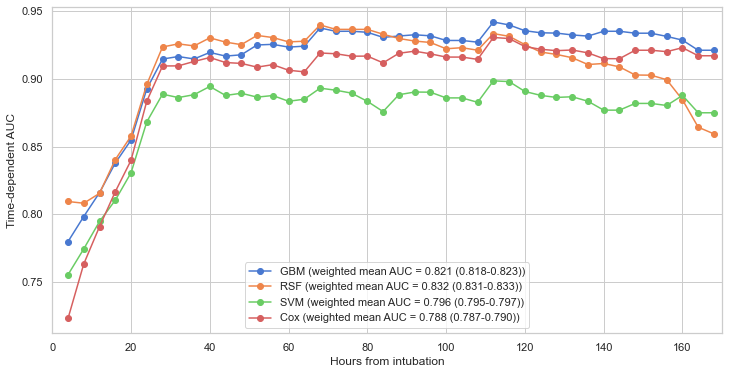

In [392]:
#Plotting time dependent C-Index
import seaborn as sns

plt.figure(figsize=(12,6))
sns.set_theme(style='whitegrid',palette='muted')
plt.xlim(0, 170)
plt.plot(va_times, gbmcv['auc_df']['auc_mean'], "o-", label="GBM (weighted mean AUC = %.3f (%.3f-%.3f))" % (gbmcv['mean_auc_df']['mean'][0], gbmcv['mean_auc_df']['2.5%'][0], gbmcv['mean_auc_df']['97.5%'][0]))
plt.plot(va_times, rsfcv['auc_df']['auc_mean'], "o-", label="RSF (weighted mean AUC = %.3f (%.3f-%.3f))" % (rsfcv['mean_auc_df']['mean'][0], rsfcv['mean_auc_df']['2.5%'][0], rsfcv['mean_auc_df']['97.5%'][0]))
plt.plot(va_times, svmcv['auc_df']['auc_mean'], "o-", label="SVM (weighted mean AUC = %.3f (%.3f-%.3f))" % (svmcv['mean_auc_df']['mean'][0], svmcv['mean_auc_df']['2.5%'][0], svmcv['mean_auc_df']['97.5%'][0]))
plt.plot(va_times, cphcv['auc_df']['auc_mean'], "o-", label="Cox (weighted mean AUC = %.3f (%.3f-%.3f))" % (cphcv['mean_auc_df']['mean'][0], cphcv['mean_auc_df']['2.5%'][0], cphcv['mean_auc_df']['97.5%'][0]))
plt.xlabel("Hours from intubation")
plt.ylabel("Time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)

plt.savefig('4 models - Time dependent AUC.png', dpi=600,  bbox_inches = "tight")

#### 2.3.4 Table 3: Integrated brier scores

In [382]:
kmcv = {}

for i in tqdm(list(range(folds))):
    # Initialise times to integrate over
    lower, upper = np.percentile(trainDict['y'+str(i)]["Survival"], [0, 100])
    vent_times = np.arange(4, 168)
    for dict in [rsfcv, gbmcv, cphcv]:
        dict['prob_'+str(i)] = np.row_stack([
            fn(vent_times)
            for fn in dict['surv_func_'+str(i)]
            ])
        try:
            dict['ibs_'+str(i)] = integrated_brier_score(y_to_np(trainDict['y'+str(i)]), y_to_np(y_final_test), dict['prob_'+str(i)], vent_times)            
        except:
            print(i)
            dict['ibs_'+str(i)] = dict['ibs_'+str(i-1)]
    try:
        km_func = StepFunction(
                *kaplan_meier_estimator(trainDict['y'+str(i)]["Censor"], trainDict['y'+str(i)]["Survival"]))
        kmcv['prob_'+str(i)] = np.tile(km_func(vent_times), (y_to_np(y_final_test).shape[0], 1))
        kmcv['ibs_'+str(i)] = integrated_brier_score(y_to_np(trainDict['y'+str(i)]), y_to_np(y_final_test), kmcv['prob_'+str(i)], vent_times)
    except:
        kmcv['ibs_'+str(i)] = kmcv['ibs_'+str(i-1)] 
    

random_surv_prob = 0.5 * np.ones(
    (y_final_test.shape[0], vent_times.shape[0])
)

 60%|██████    | 6/10 [00:10<00:07,  1.97s/it]

6
6
6


100%|██████████| 10/10 [00:14<00:00,  1.49s/it]


In [377]:
dict['prob_'+str(i)] = np.row_stack([
            fn(vent_times)
            for fn in dict['surv_func_'+str(i)]
            ])
dict['prob_'+str(i)] 

array([[9.98197642e-01, 9.87129128e-01, 9.46930496e-01, ...,
        2.07143374e-08, 2.00968975e-08, 1.81544143e-08],
       [9.99077272e-01, 9.93392756e-01, 9.72481296e-01, ...,
        1.16950864e-04, 1.15153796e-04, 1.09316828e-04],
       [9.99291383e-01, 9.94922551e-01, 9.78800766e-01, ...,
        9.56558931e-04, 9.45252049e-04, 9.08239408e-04],
       ...,
       [9.98274700e-01, 9.87676477e-01, 9.49142615e-01, ...,
        4.41636311e-08, 4.29027474e-08, 3.89248914e-08],
       [9.97847050e-01, 9.84642147e-01, 9.36928772e-01, ...,
        6.60745565e-10, 6.37284136e-10, 5.64403530e-10],
       [9.98488093e-01, 9.89193590e-01, 9.55294659e-01, ...,
        3.59292195e-07, 3.50287957e-07, 3.21660777e-07]])

In [394]:
for dict in [rsfcv, gbmcv, kmcv, cphcv]:
        dict['ibs_df'] = pd.DataFrame()
        temp_df2 = pd.DataFrame(data=[dict['ibs_'+str(i)] for i in list(range(folds))]).T
        dict['ibs_df'][['2.5%','97.5%']] = pd.DataFrame(data=list(temp_df2.apply(lambda x: stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x)), axis=1)),columns=['2.5%','97.5%'])[['2.5%','97.5%']]
        dict['ibs_df']['mean'] = pd.DataFrame(data=list(temp_df2.apply(lambda x: np.mean(x), axis=1)))
        print(dict['ibs_df'])

       2.5%     97.5%      mean
0  0.040648  0.040796  0.040722
       2.5%     97.5%      mean
0  0.043257  0.044972  0.044115
       2.5%    97.5%      mean
0  0.106464  0.10737  0.106917
       2.5%     97.5%      mean
0  0.043844  0.044152  0.043998


In [395]:
table3 = pd.DataFrame()
for name, dict in [('GBM',gbmcv),('RSF',rsfcv),('CPH',cphcv),('KM',kmcv)]:
    table3.at['IBS',name] =  "{} ({} - {})".format(round(dict['ibs_df']['mean'][0],3), round(dict['ibs_df']['2.5%'][0],3), round(dict['ibs_df']['97.5%'][0],3))
table3 = table3.T
# {'GBM': "{0:.3f} ({1:.3f} - {2:.3f})".format(gbmcv['ibs_df']['mean'], gbmcv['ibs_df']['2.5%'][0], gbmcv['ibs_df']['97.5%'][0]),
#      'RSF': "{0:.3f} ({1:.3f} - {2:.3f})".format(gbmcv['ibs_df']['mean'][0], gbmcv['ibs_df']['2.5%'][0], gbmcv['ibs_df']['97.5%'][0]),
#      'SVM': "N/A",
#      'CPH': "{0:.3f} ({1:.3f} - {2:.3f})".format(cphcv['ibs_df']['mean'][0], cphcv['ibs_df']['2.5%'][0], cphcv['ibs_df']['97.5%'][0]),
#      'KM': "{0:.3f} ({1:.3f} - {2:.3f})".format(kmcv['ibs_df']['mean'][0], kmcv['ibs_df']['2.5%'][0], kmcv['ibs_df']['97.5%'][0]),
#      'Random' : "0.25"
#     })
svmline = pd.DataFrame({"IBS":"N/A"}, index=['SVM'])
randline = pd.DataFrame({"IBS":"0.250 (0.250-0.250)"}, index=['Random'])
table3 = pd.concat([table3.iloc[:2], svmline, table3.iloc[2:], randline],axis=0)
table3.to_csv(r'table3.csv')
table3


,IBS
GBM,0.044 (0.043 - 0.045)
RSF,0.041 (0.041 - 0.041)
SVM,N/A
CPH,0.044 (0.044 - 0.044)
KM,0.107 (0.106 - 0.107)
Random,0.250 (0.250-0.250)


### 2.4: Feature importance

In [406]:
from sklearn.inspection import permutation_importance

X_test = Scaler.transform(X_final_test)
y_test = y_final_test

rsf_cal_result = permutation_importance(
    rsf, X_test, y_test, scoring = score_survival_model, n_repeats=15, random_state=42
)

gbm_cal_result = permutation_importance(
    gbm, X_test, y_test, scoring = score_survival_model, n_repeats=15, random_state=42
)

In [463]:
# Dump feat imp results 
with open("feat_imp_1.pickle", "wb") as file:
    pickle.dump(rsf_cal_result, file)
    pickle.dump(gbm_cal_result, file)

In [ ]:
# Load tuning results dictionaries
with open("feat_imp_1.pickle", "wb") as file:
    pickle.load(rsf_cal_result, file)
    pickle.load(gbm_cal_result, file)

In [414]:
rsf_cal_df = pd.DataFrame(
    {k: rsf_cal_result[k] for k in ("importances_mean", "importances_std",)},
    index=X_final_test.columns
    ).sort_values(by="importances_mean", ascending=False).reset_index()

gbm_cal_df = pd.DataFrame(
    {k: gbm_cal_result[k] for k in ("importances_mean", "importances_std",)},
    index=X_final_test.columns
    ).sort_values(by="importances_mean", ascending=False).reset_index()

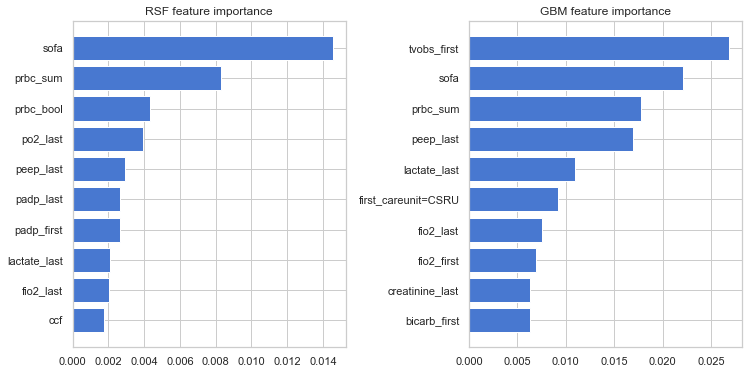

In [465]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
plt.subplots_adjust(wspace=0.45)
ax[0].barh(rsf_cal_df['index'][0:10].sort_values(),rsf_cal_df['importances_mean'][0:10].sort_values())
ax[0].set_title('RSF feature importance')
ax[1].barh(gbm_cal_df['index'][0:10].sort_values(),gbm_cal_df['importances_mean'][0:10].sort_values())
ax[1].set_title('GBM feature importance')
fig.savefig('feat_imp.png', dpi=600)

In [417]:
rsf_cal_df['importances_mean'][0:10]

0    0.014549
1    0.008308
2    0.004338
3    0.003949
4    0.002954
5    0.002641
6    0.002641
7    0.002106
8    0.002041
9    0.001761
Name: importances_mean, dtype: float64

In [427]:
gbm_cal_df[-10:]

,index,importances_mean,importances_std
176,meanbp_first,-0.000342,0.000242
177,glucose_first,-0.000347,0.000469
178,wcc_last,-0.000364,0.000563
179,language=RUSS,-0.000444,0.000240
180,potassium_first,-0.000460,0.000427
181,first_careunit=CVICU,-0.000482,0.000407
182,chloride_last,-0.000661,0.000340
183,sodium_last,-0.000699,0.000690
184,copd,-0.000777,0.000365
185,language=PORT,-0.000908,0.000372


In [502]:
gbm_cal_df.to_csv(r'gbm_featimp_table.csv')
rsf_cal_df.to_csv(r'rsf_featimp_table.csv')

### 2.5 Model Fairness

In [469]:
test_df = pd.concat([X_final_test, y_final_test], axis=1)
m_test_df = test_df[test_df['gender=M']>=0]
f_test_df = test_df[test_df['gender=M']<0]
print('# of Male: ', len(m_test_df), '# of Female: ', len(f_test_df))

X_test_M = m_test_df[[i for i in m_test_df.columns if i not in ['Survival','Censor','index']]]
y_test_M_ = m_test_df[['Survival','Censor']]
y_test_M = np.zeros(len(y_test_M_), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y_test_M['Censor'] = y_test_M_['Censor']
y_test_M['Survival'] = y_test_M_['Survival']

X_test_F = f_test_df[[i for i in f_test_df.columns if i not in ['Survival','Censor','index']]]
y_test_F_ = f_test_df[['Survival','Censor']]
y_test_F = np.zeros(len(y_test_F_), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y_test_F['Censor'] = y_test_F_['Censor']
y_test_F['Survival'] = y_test_F_['Survival']

test_df_white = test_df[test_df['ethnicity=white']>=0]
test_df_notWhite = test_df[test_df['ethnicity=white']<0]
print('# of White: ', len(test_df_white),'# of non-White: ',len(test_df_notWhite))

X_test_white = test_df_white[[i for i in test_df_white.columns if i not in ['Survival','Censor','index']]]
y_test_white_ = test_df_white[['Survival','Censor']]
y_test_white = np.zeros(len(y_test_white_), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y_test_white['Censor'] = y_test_white_['Censor']
y_test_white['Survival'] = y_test_white_['Survival']

X_test_notWhite = test_df_notWhite[[i for i in test_df_notWhite.columns if i not in ['Survival','Censor','index']]]
y_test_notWhite_ = test_df_notWhite[['Survival','Censor']]
y_test_notWhite = np.zeros(len(y_test_notWhite_), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y_test_notWhite['Censor'] = y_test_notWhite_['Censor']
y_test_notWhite['Survival'] = y_test_notWhite_['Survival']

1486 600


In [479]:
# Loop over CV folds to perform hyperparameter tuning
for i in tqdm(list(range(folds))):
    # Downsample X_train and y_train if needed, using `frac`, get X_test, y_test
    X_train = trainDict['X'+str(i)].reset_index(drop=True)
    y_train = pd.DataFrame(trainDict['y'+str(i)]).reset_index(drop=True)
    tempconcat = pd.concat([X_train, y_train],axis=1).sample(frac=frac).reset_index(drop=True)
    X_train = tempconcat.drop(['Survival','Censor'],axis=1)
    y_train = y_to_np(tempconcat[['Survival','Censor']])

    # Fit scaler to training data
    Scaler = StandardScaler().fit(X_train, y=None)

    # - 1. RSF
    rsf = RandomSurvivalForest(random_state=42)
    rsf.set_params(**rsfbestparam)
    rsf.fit(Scaler.transform(X_train), y_train)

    # - 2. GBM
    gbm = GradientBoostingSurvivalAnalysis(random_state=42)
    gbm.set_params(**gbmbestparam)
    gbm.fit(Scaler.transform(X_train),y_train)

    # X_train = trainDict['X'+str(i)]
    # y_train = y_to_np(trainDict['y'+str(i)])
    for subset, X, y in tqdm([('male', X_test_M, y_test_M), ('female', X_test_F,y_test_F), ('white', X_test_white,y_test_white), ('notWhite', X_test_notWhite, y_test_notWhite)]):
        X_test = X
        y_test = y_to_np(y)

        va_times = np.arange(4, 169, 4)
        
        # - 1. RSF
        rsf_chf_funcs = rsf.predict_cumulative_hazard_function(Scaler.transform(X_test), return_array=False)
        rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])
        rsf_surv_func = rsf.predict_survival_function(Scaler.transform(X_test))
        try:
            rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, va_times)
        except:
            print('1.'+str(i), va_times)
            print(y_test['Survival'].min(), ' - ', y_test['Survival'].max())
            rsf_auc, rsf_mean_auc = rsf_auc, rsf_mean_auc
        rsf_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], rsf.predict(Scaler.transform(X_test)))[0]
        rsfcv['mean_auc_'+str(i)+'_'+subset] = rsf_mean_auc
        rsfcv['auc_'+str(i)+'_'+subset] = rsf_auc
        rsfcv['ci_'+str(i)+'_'+subset] = rsf_ci
        rsfcv['chf_'+str(i)+'_'+subset] = rsf_chf_funcs
        rsfcv['risk_'+str(i)+'_'+subset] = rsf_risk_scores
        rsfcv['surv_func_'+str(i)+'_'+subset] = rsf_surv_func

        # - 2. GBM
        gbm_chf_funcs = gbm.predict_cumulative_hazard_function(Scaler.transform(X_test))
        gbm_risk_scores = np.row_stack([chf(va_times) for chf in gbm_chf_funcs])
        gbm_surv_func = gbm.predict_survival_function(Scaler.transform(X_test))
        try:
            gbm_auc, gbm_mean_auc = cumulative_dynamic_auc(y_train, y_test, gbm_risk_scores, va_times)
        except:
            print('2.'+str(i), va_times)
            print(y_test['Survival'].min(), ' - ', y_test['Survival'].max())
            gbm_auc, gbm_mean_auc = gbm_auc, gbm_mean_auc
        gbm_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], gbm.predict(Scaler.transform(X_test)))[0]
        gbmcv['mean_auc_'+str(i)+'_'+subset] = gbm_mean_auc
        gbmcv['auc_'+str(i)+'_'+subset] = gbm_auc
        gbmcv['ci_'+str(i)+'_'+subset] = gbm_ci
        gbmcv['chf_'+str(i)+'_'+subset] = gbm_chf_funcs
        gbmcv['risk_'+str(i)+'_'+subset] = gbm_risk_scores
        gbmcv['surv_func_'+str(i)+'_'+subset] = gbm_surv_func

 60%|██████    | 6/10 [9:50:00<6:37:23, 5960.89s/it]

1.6 [  4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72
  76  80  84  88  92  96 100 104 108 112 116 120 124 128 132 136 140 144
 148 152 156 160 164 168]
0.75  -  821.05


2.6 [  4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72
  76  80  84  88  92  96 100 104 108 112 116 120 124 128 132 136 140 144
 148 152 156 160 164 168]
0.75  -  821.05


1.6 [  4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72
  76  80  84  88  92  96 100 104 108 112 116 120 124 128 132 136 140 144
 148 152 156 160 164 168]
0.75  -  821.05


2.6 [  4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72
  76  80  84  88  92  96 100 104 108 112 116 120 124 128 132 136 140 144
 148 152 156 160 164 168]
0.75  -  821.05


100%|██████████| 10/10 [16:22:21<00:00, 5894.15s/it] 


In [481]:
from scipy import stats

folds = 10

for dict in [rsfcv, gbmcv]:
    for subset in ['male','female','white','notWhite']:
        dict['auc_df'+'_'+subset] = pd.DataFrame()
        temp_df1 = pd.DataFrame(data=[dict['auc_'+str(i)+'_'+subset] for i in list(range(folds))], columns = va_times).T
        dict['auc_df'+'_'+subset][['auc_2.5%','auc_97.5%']] = pd.DataFrame(data=list(temp_df1.apply(lambda x: stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x)), axis=1)),columns=['2.5%','97.5%'])[['2.5%','97.5%']]
        dict['auc_df'+'_'+subset]['auc_mean'] = pd.DataFrame(data=list(temp_df1.apply(lambda x: np.mean(x), axis=1)))
        print(dict['auc_df'+'_'+subset])

    auc_2.5%  auc_97.5%  auc_mean
0   0.796558   0.803936  0.800247
1   0.801170   0.804293  0.802731
2   0.813536   0.819901  0.816719
3   0.844149   0.847744  0.845947
4   0.854949   0.858750  0.856850
5   0.907961   0.911083  0.909522
6   0.928999   0.932007  0.930503
7   0.928258   0.930833  0.929545
8   0.924712   0.927841  0.926276
9   0.927310   0.933893  0.930601
10  0.925107   0.928691  0.926899
11  0.923865   0.929090  0.926477
12  0.932333   0.939913  0.936123
13  0.928437   0.936920  0.932678
14  0.922266   0.934104  0.928185
15  0.922736   0.933933  0.928334
16  0.925053   0.939441  0.932247
17  0.920097   0.933810  0.926954
18  0.918777   0.932372  0.925574
19  0.908432   0.932783  0.920607
20  0.899898   0.927530  0.913714
21  0.895511   0.922705  0.909108
22  0.891924   0.920768  0.906346
23  0.886480   0.918922  0.902701
24  0.873835   0.916284  0.895059
25  0.873276   0.917110  0.895193
26  0.874970   0.917838  0.896404
27  0.875642   0.937767  0.906705
28  0.871754  

In [482]:
for metric in ['ci_','mean_auc_']:
    for dict in [rsfcv, gbmcv]:
        for subset in ['male','female','white','notWhite']:
            dict[metric+'df'+'_'+subset] = pd.DataFrame()
            temp_df2 = pd.DataFrame(data=[dict[metric+str(i)+'_'+subset] for i in list(range(folds))]).T
            dict[metric+'df'+'_'+subset][['2.5%','97.5%']] = pd.DataFrame(data=list(temp_df2.apply(lambda x: stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x)), axis=1)),columns=['2.5%','97.5%'])[['2.5%','97.5%']]
            dict[metric+'df'+'_'+subset]['mean'] = pd.DataFrame(data=list(temp_df2.apply(lambda x: np.mean(x), axis=1)))
            print(dict[metric+'df'+'_'+subset])

      2.5%     97.5%      mean
0  0.69769  0.700611  0.699151
       2.5%     97.5%      mean
0  0.706142  0.711474  0.708808
       2.5%     97.5%      mean
0  0.699909  0.702438  0.701174
       2.5%     97.5%      mean
0  0.712717  0.717368  0.715043
       2.5%     97.5%      mean
0  0.714641  0.721223  0.717932
      2.5%     97.5%      mean
0  0.72506  0.729141  0.727101
       2.5%    97.5%      mean
0  0.717274  0.72207  0.719672
       2.5%    97.5%      mean
0  0.730335  0.73918  0.734758
       2.5%     97.5%     mean
0  0.826774  0.828566  0.82767
       2.5%     97.5%      mean
0  0.834543  0.837486  0.836015
       2.5%     97.5%      mean
0  0.828975  0.832692  0.830834
       2.5%     97.5%      mean
0  0.830155  0.833787  0.831971
       2.5%     97.5%      mean
0  0.812904  0.823439  0.818172
      2.5%     97.5%      mean
0  0.82207  0.827995  0.825033
       2.5%     97.5%      mean
0  0.814263  0.819418  0.816841
       2.5%    97.5%      mean
0  0.836613  0.84822 

In [491]:
# Table with AUC at 12h, 24h, 2d, 3d, 7d

for dict in [rsfcv, gbmcv]:
    for metric in ['mean_auc','ci']:
        dict['results_list_fairness_'+metric] = []
        for subset in ['male','female','white','notWhite']:
            dict['results_list_fairness_'+metric].append("{0:.3f} ({1:.3f} - {2:.3f})".format(dict[metric+'_df'+'_'+subset]['mean'][0], dict[metric+'_df'+'_'+subset]['2.5%'][0], dict[metric+'_df'+'_'+subset]['97.5%'][0]))
        dict['results_list_fairness_'+metric].append("{0:.3f} ({1:.3f} - {2:.3f})".format(dict[metric+'_df']['mean'][0], dict[metric+'_df']['2.5%'][0], dict[metric+'_df']['97.5%'][0]))

table4 = pd.DataFrame(
    {'GBM mean AUC': gbmcv['results_list_fairness_mean_auc'],
     'RSF mean AUC': rsfcv['results_list_fairness_mean_auc'],
     'GBM CI': gbmcv['results_list_fairness_ci'],
     'RSF CI': rsfcv['results_list_fairness_ci']
    }).T.rename({0:'Male',1:'Female',2:'White',3:'Non-White',4:'Original test sample'}, axis=1) 
table4.to_csv(r'table4.csv')
table4

,Male,Female,White,Non-White,Original test sample
GBM mean AUC,0.818 (0.813 - 0.823),0.825 (0.822 - 0.828),0.817 (0.814 - 0.819),0.842 (0.837 - 0.848),0.821 (0.818 - 0.823)
RSF mean AUC,0.828 (0.827 - 0.829),0.836 (0.835 - 0.837),0.831 (0.829 - 0.833),0.832 (0.830 - 0.834),0.832 (0.831 - 0.833)
GBM CI,0.718 (0.715 - 0.721),0.727 (0.725 - 0.729),0.720 (0.717 - 0.722),0.735 (0.730 - 0.739),0.722 (0.719 - 0.724)
RSF CI,0.699 (0.698 - 0.701),0.709 (0.706 - 0.711),0.701 (0.700 - 0.702),0.715 (0.713 - 0.717),0.704 (0.702 - 0.705)


In [488]:
gbmcv['results_list_fairness_mean_auc']

['0.818 (0.813 - 0.823)',
 '0.825 (0.822 - 0.828)',
 '0.817 (0.814 - 0.819)',
 '0.842 (0.837 - 0.848)',
 '0.821 (0.818 - 0.823)']

### 2.3 Model evaluation (CV) 

In [ ]:
rfbestparam = {'min_samples_leaf': 6, 'n_estimators': 100}
gbmbestparam = {'learning_rate': 0.3, 'n_estimators': 100}
svmbestparam = {'alpha': 0.1, 'max_iter': 100}
coxbestparam = {'coxnetsurvivalanalysis__alphas': [best_alpha]}

In [ ]:
# 5-Fold CV to get concordance index -> done later with weighted mean AUC 
'''from sklearn.model_selection import cross_val_score

random_state = 0
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Censor"], y["Survival"], prediction)
    return result[0]

#Random forest
rf_scores = cross_val_score(RandomSurvivalForest(**rfbestparam, random_state=random_state), Xt_scaled, y, cv=5, scoring=score_survival_model)
print(rf_scores)

#GBM
gbm_scores = cross_val_score(GradientBoostingSurvivalAnalysis(**gbmbestparam, random_state=random_state), Xt_scaled, y, cv=5, scoring=score_survival_model)
print(gbm_scores)

#SVM
svm_scores = cross_val_score(FastSurvivalSVM(**svmbestparam, random_state=random_state), Xt_scaled, y, cv=5, scoring=score_survival_model)
print(svm_scores)

#Coxnet
coxnet = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.5)
)
coxnet.set_params(**coxbestparam)
cox_scores = cross_val_score(coxnet, Xt, y, cv=5, scoring=score_survival_model)
print(cox_scores)

print('RF: %.3f (%.3f-%.3f)' % (rf_scores.mean(), min(rf_scores), max(rf_scores)))
print('GBM: %.3f (%.3f-%.3f)' % (gbm_scores.mean(), min(gbm_scores), max(gbm_scores)))
print('SVM: %.3f (%.3f-%.3f)' % (svm_scores.mean(), min(svm_scores), max(svm_scores)))
print('Cox: %.3f (%.3f-%.3f)' % (cox_scores.mean(), min(cox_scores), max(cox_scores)))
[[0.727, 0.734], [0.73, 0.742], [0.725, 0.733], [0.617, 0.634]]'''

In [ ]:
Xt_scaled

In [ ]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)
Xt = Xt.drop(['first_careunit=Neuro Inter','admission_type=DIRECT OBSERVATION'],axis=1)
Xt_columns = list(Xt.columns)
Xt_scaled = StandardScaler().fit_transform(Xt, y=None)
Xt_scaled = pd.DataFrame(data=Xt_scaled,columns=Xt_columns)
Scaler = StandardScaler().fit(Xt,y=None)

df['duration1'] = df['duration1'].replace({0.0: 1})
y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

Xt_scaled['Censor'] = df['censor']
Xt_scaled['Survival'] = df['duration1']

In [ ]:
Xt_smogn = smogn.smoter(
            ## main arguments
            data = Xt_scaled,           ## pandas dataframe
            y = 'Survival',          ## string ('header name')
            k = 9,                    ## positive integer (k < n)
            samp_method = 'extreme',  ## string ('balance' or 'extreme')

            ## phi relevance arguments
            rel_thres = 0.80,         ## positive real number (0 < R < 1)
            rel_method = 'auto',      ## string ('auto' or 'manual')
            rel_xtrm_type = 'high',   ## string ('low' or 'both' or 'high')
            rel_coef = 2.25           ## positive real number (0 < R)
)

In [ ]:
#for smogn testing: run this cell, ignore next two
#4:1 split to get a single CD-AUC curve for each model to plot
#Get train-test split for testing
X_smogn = Xt_smogn.drop(columns=['Survival','Censor'])
y_smogn = np.zeros(len(Xt_smogn), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})
y_smogn['Censor'] = Xt_smogn['Censor']
y_smogn['Survival'] = Xt_smogn['Survival']

X_train, X_test, y_train, y_test = train_test_split(
    X_smogn, y_smogn, test_size=0.1, stratify=y_smogn["Censor"], random_state=42)

#Set the range of time points
va_times = np.concatenate([np.arange(1, 48), np.arange(48, 672, 20)])
va_times = np.arange(4, 169, 4)

#Get CD-AUC for all models
# - 1. RF
Scaler = StandardScaler().fit(Xt, y=None)
rsf = RandomSurvivalForest(random_state=42)
rsf.set_params(**rfbestparam)
rsf.fit(Scaler.transform(X_train), y_train)
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(Scaler.transform(X_test), return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])
rsf_surv_func = rsf.predict_survival_function(Scaler.transform(X_test))
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, va_times)
rsf_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], rsf.predict(Scaler.transform(X_test)))[0]

# - 2. GBM
Scaler = StandardScaler().fit(Xt, y=None)
gbm = GradientBoostingSurvivalAnalysis(random_state=42)
gbm.set_params(**gbmbestparam)
gbm.fit(Scaler.transform(X_train),y_train)
gbm_chf_funcs = gbm.predict_cumulative_hazard_function(Scaler.transform(X_test))
gbm_risk_scores = np.row_stack([chf(va_times) for chf in gbm_chf_funcs])
gbm_surv_func = gbm.predict_survival_function(Scaler.transform(X_test))
gbm_auc, gbm_mean_auc = cumulative_dynamic_auc(y_train, y_test, gbm_risk_scores, va_times)
gbm_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], gbm.predict(Scaler.transform(X_test)))[0]


# - 3. SVM
Scaler = StandardScaler().fit(Xt, y=None)
svm = FastSurvivalSVM(**svmbestparam, random_state=42)
svm.set_params(**svmbestparam)
svm.fit(Scaler.transform(X_train),y_train)
svm_predict = svm.predict(Scaler.transform(X_test))
df_temp = pd.DataFrame(y_test['Survival'], columns=['Duration'])
df_temp['Predict'] = pd.Series(svm_predict)
svm_error = df_temp.apply(lambda row: row['Predict'] - row['Duration'], axis=1)
svm_auc, svm_mean_auc = cumulative_dynamic_auc(y_train, y_test, svm_predict, va_times)
svm_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], svm.predict(Scaler.transform(X_test)))[0]

# - 4. CoxNet
coxnet_pred = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
)
coxnet_pred.set_params(**coxbestparam)
coxnet_pred.fit(X_train, y_train)
cph_risk_scores = coxnet_pred.predict(X_test)
cph_surv_func = coxnet_pred.predict_survival_function(X_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, va_times)
cph_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], coxnet_pred.predict(Scaler.transform(X_test)))[0]

In [ ]:
#4:1 split to get a single CD-AUC curve for each model to plot
#Get train-test split for testing
X_smogn = Xt_smogn.drop(columns=['Survival','Censor'])
y_smogn = np.zeros(len(Xt_smogn), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})
y_smogn['Censor'] = Xt_smogn['Censor']
y_smogn['Survival'] = Xt_smogn['Survival']

X_train, X_test, y_train, y_test = train_test_split(
    X_smogn, y_smogn, test_size=0.1, stratify=y_smogn["Censor"], random_state=88)

In [ ]:
#Set the range of time points
va_times = np.concatenate([np.arange(1, 48), np.arange(48, 672, 20)])
va_times = np.arange(4, 169, 4)

#Get CD-AUC for all models
# - 1. RF
rsf = RandomSurvivalForest(random_state=42)
rsf.set_params(**rfbestparam)
rsf.fit(X_train, y_train)
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])
rsf_surv_func = rsf.predict_survival_function(X_test)
rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, va_times)
rsf_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], rsf.predict(X_test))[0]

# - 2. GBM
gbm = GradientBoostingSurvivalAnalysis(random_state=42)
gbm.set_params(**gbmbestparam)
gbm.fit(X_train,y_train)
gbm_chf_funcs = gbm.predict_cumulative_hazard_function(X_test)
gbm_risk_scores = np.row_stack([chf(va_times) for chf in gbm_chf_funcs])
gbm_surv_func = gbm.predict_survival_function(X_test)
gbm_auc, gbm_mean_auc = cumulative_dynamic_auc(y_train, y_test, gbm_risk_scores, va_times)
gbm_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], gbm.predict(X_test))[0]

# - 3. SVM
svm = FastSurvivalSVM(**svmbestparam, random_state=42)
svm.set_params(**svmbestparam)
svm.fit(X_train,y_train)
svm_predict = svm.predict(X_test)
df_temp = pd.DataFrame(y_test['Survival'], columns=['Duration'])
df_temp['Predict'] = pd.Series(svm_predict)
svm_error = df_temp.apply(lambda row: row['Predict'] - row['Duration'], axis=1)
svm_auc, svm_mean_auc = cumulative_dynamic_auc(y_train, y_test, svm_predict, va_times)
svm_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], svm.predict(X_test))[0]

# - 4. CoxNet
coxnet_pred = make_pipeline(
    CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
)
coxnet_pred.set_params(**coxbestparam)
coxnet_pred.fit(X_train, y_train)
cph_risk_scores = coxnet_pred.predict(X_test)
cph_surv_func = coxnet_pred.predict_survival_function(X_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, va_times)
cph_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], coxnet_pred.predict(X_test))[0]

In [ ]:
# Print AUC at 12h, 24h, 2d, 3d, 7d
print(gbm_auc[[2,5,11,17,41]],
rsf_auc[[2,5,11,17,41]],
svm_auc[[2,5,11,17,41]],
cph_auc[[2,5,11,17,41]],)

In [ ]:
# Table with AUC at 12h, 24h, 2d, 3d, 7d
lst1 = gbm_auc[[2,5,11,17,41]]
lst2 = rsf_auc[[2,5,11,17,41]]
lst3 = svm_auc[[2,5,11,17,41]]
lst4 = cph_auc[[2,5,11,17,41]]

pointAUCs = pd.DataFrame(
    {'GBM': lst1,
     'RSF': lst2,
     'SVM': lst3,
     'CPH': lst4
    }).T.rename({0:'12h',1:'24h',2:'2d',3:'3d',4:'7d'}, axis=1) 
pointAUCs.to_csv('pointAUCs.csv')
pointAUCs

In [ ]:
# CHF - ignore
'''index_list = [1489,385,118,1915,997,818,1993,237,40,128,1580,1312,1753,1465]
example_chfs = X_test.reset_index(drop=True).loc[index_list,:]
example_durations = list(pd.DataFrame(y_test).loc[index_list,:]['Survival'])
import seaborn as sns

chf_funcs = rsf.predict_cumulative_hazard_function(Scaler.transform(example_chfs))
plt.figure(figsize=(10,5))
sns.set_theme(style='whitegrid',palette='muted')
for i in range(len(chf_funcs)):
    plt.step(chf_funcs[i].x, chf_funcs[i](chf_funcs[i].x), where="post", label=example_durations[i])
plt.xlabel("Hours from intubation")
plt.ylabel("Estimated probability of extubation")
plt.ylim(0, 1)
plt.xlim(0,168)
plt.legend(loc="center right",title='True extubation time',fancybox=True)
plt.grid(True)
plt.savefig('predicted chfs.png', dpi=600,  bbox_inches = "tight")'''

In [374]:
# get ventilation duration prediction from survival functions
def surv_predict(surv_funcs):
    pred_list = []
    for i in range(len(surv_funcs)):
        df_survf = pd.DataFrame([surv_funcs[i].x, surv_funcs[i](surv_funcs[i].x)]).T
        try:
            biggerTime = df_survf[df_survf[1]>=0.5].sort_values(by=[1],ascending=True).reset_index(drop=True).loc[0,0]
            smallerTime = df_survf[df_survf[1]<=0.5].sort_values(by=[1],ascending=False).reset_index(drop=True).loc[0,0]
            meanTime = (biggerTime + smallerTime)/2
            pred_list.append(meanTime)
        except:
            pred_list.append(np.NaN)
            print(i)
            continue
    df_temp = pd.DataFrame()
    df_temp['Duration'] = pd.Series(y_final_test['Survival'].reset_index(drop=True))
    df_temp['Predict'] = pd.Series(pred_list)
    df_temp['Error'] = df_temp.apply(lambda row: row['Predict'] - row['Duration'], axis=1)
    print(df_temp)
    return df_temp['Error'], df_temp['Predict']

In [375]:
# get Series of absolute error and predicted ventilation duration for each model
svm_error = svmcv['error_0']
rsf_error, rsf_predict = surv_predict(rsfcv['surv_func_0'])
gbm_error, gbm_predict = surv_predict(gbmcv['surv_func_0'])
cph_error, cph_predict = surv_predict(cphcv['surv_func_0'])

       Duration    Predict      Error
0      8.000000  12.933333   4.933333
1      5.000000  14.983333   9.983333
2     45.183333  17.966667 -27.216667
3      6.000000   9.458333   3.458333
4     17.000000   8.991667  -8.008333
...         ...        ...        ...
2081   3.483333   5.816667   2.333333
2082   6.000000   7.958333   1.958333
2083   4.000000   6.050000   2.050000
2084  20.000000   7.958333 -12.041667
2085   3.000000  14.741667  11.741667

[2086 rows x 3 columns]
       Duration    Predict      Error
0      8.000000   8.483333   0.483333
1      5.000000  20.025000  15.025000
2     45.183333  19.958333 -25.225000
3      6.000000  11.975000   5.975000
4     17.000000   8.991667  -8.008333
...         ...        ...        ...
2081   3.483333   5.991667   2.508333
2082   6.000000   7.958333   1.958333
2083   4.000000   7.958333   3.958333
2084  20.000000   8.991667 -11.008333
2085   3.000000  15.366667  12.366667

[2086 rows x 3 columns]
       Duration    Predict      Error


In [370]:
# get Df with absolute error, predicted vent duration, actual duration
gbm_df = pd.DataFrame(gbm_error, columns=['Error'])
gbm_df['Predict'] = pd.Series(gbm_predict)
gbm_df['Duration'] = pd.Series(y_final_test['Survival']).reset_index(drop=True)
gbm_df = gbm_df.dropna(axis=0)

svm_df = pd.DataFrame(svm_error, columns=['Error'])
svm_df['Predict'] = pd.Series(svm_predict)
svm_df['Duration'] = pd.Series(y_final_test['Survival']).reset_index(drop=True)
svm_df = svm_df.dropna(axis=0)

cph_df = pd.DataFrame(cph_error, columns=['Error'])
cph_df['Predict'] = pd.Series(cph_predict)
cph_df['Duration'] = pd.Series(y_final_test['Survival']).reset_index(drop=True)
cph_df = cph_df.dropna(axis=0)

rsf_df = pd.DataFrame(rsf_error, columns=['Error'])
rsf_df['Predict'] = pd.Series(rsf_predict)
rsf_df['Duration'] = pd.Series(y_final_test['Survival']).reset_index(drop=True)
rsf_df = rsf_df.dropna(axis=0)
rsf_df

base_df = pd.DataFrame([pd.DataFrame(y_1['Survival']).reset_index(drop=True).mean()[0]]*len(y_final_test['Survival'].reset_index(drop=True)), columns=['Predict'])
base_df['Duration'] = pd.Series(y_final_test['Survival']).reset_index(drop=True)
base_df['Error'] = base_df.apply(lambda row: row['Predict'] - row['Duration'], axis=1)
base_df

,Predict,Duration,Error
0,16.646174,8.000000,8.646174
1,16.646174,5.000000,11.646174
2,16.646174,45.183333,-28.537159
3,16.646174,6.000000,10.646174
4,16.646174,17.000000,-0.353826
...,...,...,...
2081,16.646174,3.483333,13.162841
2082,16.646174,6.000000,10.646174
2083,16.646174,4.000000,12.646174
2084,16.646174,20.000000,-3.353826


In [371]:
# get RMSE for each model
def rms(values):
    return np.sqrt(sum(values**2)/len(values))

svm_rms = rms(svm_df['Error'])
rsf_rms = rms(rsf_df['Error'])
gbm_rms = rms(gbm_df['Error'])
cph_rms = rms(cph_df['Error'])
base_rms = rms(base_df['Error'])
rms_df = pd.DataFrame(data = [rsf_rms, gbm_rms, svm_rms, cph_rms, base_rms], columns = ['RMSE'], index=['RSF','GBM','SVM','CPH','Baseline'])
rms_df

,RMSE
RSF,38.675934
GBM,39.912078
SVM,43.001987
CPH,36.731096
Baseline,39.741099


In [250]:
# sanity test for RF AUC at 24h 
rsf_df['Predict_24'] = rsf_df['Predict'].apply(lambda row: 0 if row < 24 else 1)
rsf_df['Predict_24'].value_counts()

rsf_df['Duration_24'] = rsf_df['Duration'].apply(lambda row: 0 if row < 24 else 1)
rsf_df['Duration_24'].value_counts()

fpr = {}
tpr = {}
auroc = {}
fpr["RSF"], tpr["RSF"], _ = roc_curve(rsf_df['Duration_24'], rsf_df['Predict'])
auroc["RSF"] = auc(fpr["RSF"], tpr["RSF"])
auroc["RSF"]

0.8783000504320959

(-10.0, 200.0)

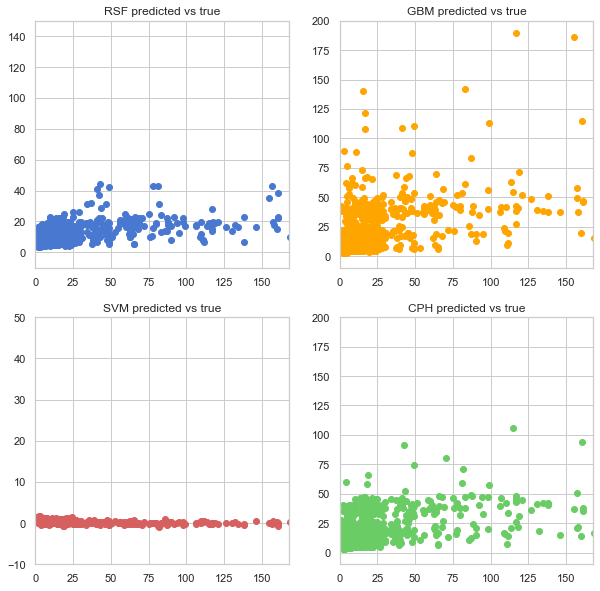

In [372]:
# plot of predicted vs true ventilation duration for each of the 4 models
import seaborn as sns
sns.set_theme(style='whitegrid',palette='muted')

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].scatter(rsf_df['Duration'], rsf_df['Predict'], c='b')
axs[0, 0].set_title('RSF predicted vs true')
axs[0, 0].set_xlim(0,168)
axs[0, 0].set_ylim(-10,150)
axs[0, 1].scatter(gbm_df['Duration'], gbm_df['Predict'], c='orange')
axs[0, 1].set_title('GBM predicted vs true')
axs[0, 1].set_xlim(0,168)
axs[0, 1].set_ylim(-10,200)
axs[1, 0].scatter(svm_df['Duration'], svm_df['Predict'], c='r')
axs[1, 0].set_title('SVM predicted vs true')
axs[1, 0].set_xlim(0,168)
axs[1, 0].set_ylim(-10,50)
axs[1, 1].scatter(cph_df['Duration'], cph_df['Predict'], c='g')
axs[1, 1].set_title('CPH predicted vs true')
axs[1, 1].set_xlim(0,168)
axs[1, 1].set_ylim(-10,200)

In [ ]:
# plot of absolute error vs true vent duration for each of the four models
import seaborn as sns
sns.set_theme(style='whitegrid',palette='muted')

fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0, 0].scatter(rsf_df['Duration'], rsf_df['Error'], c='b')
axs[0, 0].set_title('RSF error')
axs[0, 0].set_xlim(0,168)
axs[0, 0].set_ylim(-200,40)
axs[0, 1].scatter(gbm_df['Duration'], gbm_df['Error'], c='orange')
axs[0, 1].set_title('GBM error')
axs[0, 1].set_xlim(0,168)
axs[0, 1].set_ylim(-200,400)
axs[1, 0].scatter(svm_df['Duration'], svm_df['Error'], c='r')
axs[1, 0].set_title('SVM error')
axs[1, 0].set_xlim(0,168)
axs[1, 0].set_ylim(-200,40)
axs[1, 1].scatter(cph_df['Duration'], cph_df['Error'], c='g')
axs[1, 1].set_title('CPH error')
axs[1, 1].set_xlim(0,168)
axs[1, 1].set_ylim(-200,500)

In [ ]:
# 5-fold CV to get AUC and CI max and min values
def metricsCV(random_state_list):
    rsf_aucs = []
    gbm_aucs = []
    svm_aucs = []
    cph_aucs = []
    rsf_cis = []
    gbm_cis = []
    svm_cis = []
    cph_cis = []
    for random_state in random_state_list:
        #Get train-test split for testing
        X_train, X_test, y_train, y_test = train_test_split(
            Xt, y, test_size=0.2, stratify=y["Censor"], random_state=random_state)

        #Set the range of time points
        va_times = np.concatenate([np.arange(1, 48), np.arange(48, 672, 20)])
        va_times = np.arange(4, 169, 4)

        #Get CD-AUD for all models
        #1. RF
        Scaler = StandardScaler().fit(Xt, y=None)
        rsf = RandomSurvivalForest(random_state=random_state)
        rsf.set_params(**rfbestparam)
        rsf.fit(Scaler.transform(X_train), y_train)
        rsf_chf_funcs = rsf.predict_cumulative_hazard_function(Scaler.transform(X_test), return_array=False)
        rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])
        rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, va_times)
        rsf_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], rsf.predict(Scaler.transform(X_test)))[0]
        
        #2. GBM
        Scaler = StandardScaler().fit(Xt, y=None)
        gbm = GradientBoostingSurvivalAnalysis(random_state=random_state)
        gbm.set_params(**gbmbestparam)
        gbm.fit(Scaler.transform(X_train),y_train)
        gbm_chf_funcs = gbm.predict_cumulative_hazard_function(Scaler.transform(X_test))
        gbm_risk_scores = np.row_stack([chf(va_times) for chf in gbm_chf_funcs])
        gbm_auc, gbm_mean_auc = cumulative_dynamic_auc(y_train, y_test, gbm_risk_scores, va_times)
        gbm_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], gbm.predict(Scaler.transform(X_test)))[0]

        #3. SVM
        Scaler = StandardScaler().fit(Xt, y=None)
        svm = FastSurvivalSVM(**svmbestparam, random_state=random_state)
        svm.set_params(**svmbestparam)
        svm.fit(Scaler.transform(X_train),y_train)
        svm_chf_funcs = svm.predict(Scaler.transform(X_test)) #svm does not actually produce chfs
        svm_auc, svm_mean_auc = cumulative_dynamic_auc(y_train, y_test, svm_chf_funcs, va_times)
        svm_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], svm.predict(Scaler.transform(X_test)))[0]

        #4. CoxNet
        coxnet_pred = make_pipeline(
            StandardScaler(),
            CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
        )
        coxnet_pred.set_params(**coxbestparam)
        coxnet_pred.fit(X_train, y_train)
        cph_risk_scores = coxnet_pred.predict(X_test)
        cph_auc, cph_mean_auc = cumulative_dynamic_auc(y_train, y_test, cph_risk_scores, va_times)
        cph_ci = concordance_index_censored(y_test["Censor"], y_test["Survival"], coxnet_pred.predict(Scaler.transform(X_test)))[0]

        rsf_aucs.append(rsf_mean_auc)
        gbm_aucs.append(gbm_mean_auc)
        svm_aucs.append(svm_mean_auc)
        cph_aucs.append(cph_mean_auc)
        rsf_cis.append(rsf_ci)
        gbm_cis.append(gbm_ci)
        svm_cis.append(svm_ci)
        cph_cis.append(cph_ci)
    return rsf_aucs, gbm_aucs, svm_aucs, cph_aucs, rsf_cis, gbm_cis, svm_cis, cph_cis

seedList = [8,42,69,101,1337]
metricsCV_results = metricsCV(seedList)
#metricsCV_results.to_csv('metricsCV_results.csv')

In [ ]:
# max and min for models' weighted mean auc
aucList = []
for i in range(4):
    aucList.append([round(min(metricsCV_results[i]),3), round(max(metricsCV_results[i]),3)])
aucList

In [ ]:
# max and min for models' c-index
ciList = []
for i in range(4,8):
    ciList.append([round(min(metricsCV_results[i]),3), round(max(metricsCV_results[i]),3)])
ciList

In [ ]:
#Plotting time dependent C-Index
import seaborn as sns

plt.figure(figsize=(12,6))
sns.set_theme(style='whitegrid',palette='muted')
plt.xlim(0, 170)
plt.plot(va_times, gbm_auc, "o-", label="GBM (weighted mean AUC = %.3f (%.3f-%.3f))" % (gbm_mean_auc,aucList[1][0],aucList[1][1]))
plt.plot(va_times, rsf_auc, "o-", label="RSF (weighted mean AUC = %.3f (%.3f-%.3f))" % (rsf_mean_auc,aucList[0][0],aucList[0][1]))
plt.plot(va_times, svm_auc, "o-", label="SVM (weighted mean AUC = %.3f (%.3f-%.3f))" % (svm_mean_auc,aucList[2][0],aucList[2][1]))
plt.plot(va_times, cph_auc, "o-", label="Cox (weighted mean AUC = %.3f (%.3f-%.3f))" % (cph_mean_auc,aucList[3][0],aucList[3][1]))
plt.xlabel("Hours from intubation")
plt.ylabel("Time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)

plt.savefig('4 models - Time dependent AUC.png', dpi=600,  bbox_inches = "tight")


### 2.4: Model fairness (sensitivity analysis)

#### 2.4.1: Gender

In [ ]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)
Xt = Xt.drop(['first_careunit=Neuro Inter','admission_type=DIRECT OBSERVATION'],axis=1)
Scaler = StandardScaler().fit(Xt, y=None)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.2, stratify=y["Censor"], random_state=42)

In [ ]:
test_df = pd.merge(X_test.reset_index(), pd.DataFrame(y_test), left_index=True, right_index=True)
m_test_df = test_df[test_df['gender=M']==1]
f_test_df = test_df[test_df['gender=M']==0]
print(len(m_test_df),len(f_test_df))

X_test_M = m_test_df[[i for i in m_test_df.columns if i not in ['Survival','Censor','index']]]
y_test_M_ = m_test_df[['Survival','Censor']]
y_test_M = np.zeros(len(y_test_M_), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y_test_M['Censor'] = y_test_M_['Censor']
y_test_M['Survival'] = y_test_M_['Survival']

X_test_F = f_test_df[[i for i in f_test_df.columns if i not in ['Survival','Censor','index']]]
y_test_F_ = f_test_df[['Survival','Censor']]
y_test_F = np.zeros(len(y_test_F_), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y_test_F['Censor'] = y_test_F_['Censor']
y_test_F['Survival'] = y_test_F_['Survival']

In [ ]:
# Male GBM
va_times_M = np.concatenate([np.arange(1, 48), np.arange(48, 672, 24)])
gbm_chf_funcs_M = gbm.predict_cumulative_hazard_function(
    Scaler.transform(X_test_M))
gbm_risk_scores_M = np.row_stack([chf(va_times_M) for chf in gbm_chf_funcs_M])

gbm_auc_M, gbm_mean_auc_M = cumulative_dynamic_auc(
    y_train, y_test_M, gbm_risk_scores_M, va_times_M
)

# Female GBM
va_times_F = np.concatenate([np.arange(1, 48), np.arange(48, 279, 24)])
gbm_chf_funcs_F = gbm.predict_cumulative_hazard_function(
    Scaler.transform(X_test_F))
gbm_risk_scores_F = np.row_stack([chf(va_times_F) for chf in gbm_chf_funcs_F])

gbm_auc_F, gbm_mean_auc_F = cumulative_dynamic_auc(
    y_train, y_test_F, gbm_risk_scores_F, va_times_F
)

In [ ]:
#Plotting time dependent C-Index
import seaborn as sns

plt.figure(figsize=(20,10))
sns.set_theme(style='whitegrid',palette='muted')
plt.xlim(0, 168)
plt.plot(va_times_M, gbm_auc_M, "o-", label="GBM_male (mean AUC = {:.3f})".format(gbm_mean_auc_M))
plt.plot(va_times_F, gbm_auc_F, "o-", label="GBM_female (mean AUC = {:.3f})".format(gbm_mean_auc_F))
plt.xlabel("Hours from intubation")
plt.ylabel("Time-dependent AUC")
plt.legend(loc="lower left")
plt.grid(True)

#plt.savefig('Male_1/Time dependent AUC.png', dpi=300,  bbox_inches = "tight")

#### 2.4.2: Ethnicity

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.2, stratify=y["Censor"], random_state=42)

In [ ]:
test_df = pd.merge(X_test.reset_index(), pd.DataFrame(y_test), left_index=True, right_index=True)
test_df_white = test_df[test_df['ethnicity=white']==1]
test_df_notWhite = test_df[test_df['ethnicity=white']==0]
print(len(test_df_white),len(test_df_notWhite))

X_test_white = test_df_white[[i for i in test_df_white.columns if i not in ['Survival','Censor','index']]]
y_test_white_ = test_df_white[['Survival','Censor']]
y_test_white = np.zeros(len(y_test_white_), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y_test_white['Censor'] = y_test_white_['Censor']
y_test_white['Survival'] = y_test_white_['Survival']

X_test_notWhite = test_df_notWhite[[i for i in test_df_notWhite.columns if i not in ['Survival','Censor','index']]]
y_test_notWhite_ = test_df_notWhite[['Survival','Censor']]
y_test_notWhite = np.zeros(len(y_test_notWhite_), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y_test_notWhite['Censor'] = y_test_notWhite_['Censor']
y_test_notWhite['Survival'] = y_test_notWhite_['Survival']

In [ ]:
# White GBM
va_times_white = np.concatenate([np.arange(1, 48), np.arange(48, 672, 24)])
gbm_chf_funcs_white = gbm.predict_cumulative_hazard_function(
    Scaler.transform(X_test_white))
gbm_risk_scores_white = np.row_stack([chf(va_times_white) for chf in gbm_chf_funcs_white])

gbm_auc_white, gbm_mean_auc_white = cumulative_dynamic_auc(
    y_train, y_test_white, gbm_risk_scores_white, va_times_white
)

# NotWhite GBM
va_times_notWhite = np.concatenate([np.arange(1, 48), np.arange(48, 192, 24)])
gbm_chf_funcs_notWhite = gbm.predict_cumulative_hazard_function(
    Scaler.transform(X_test_notWhite))
gbm_risk_scores_notWhite = np.row_stack([chf(va_times_notWhite) for chf in gbm_chf_funcs_notWhite])

gbm_auc_notWhite, gbm_mean_auc_notWhite = cumulative_dynamic_auc(
    y_train, y_test_notWhite, gbm_risk_scores_notWhite, va_times_notWhite
)

In [ ]:
#Plotting time dependent C-Index
import seaborn as sns

plt.figure(figsize=(20,10))
sns.set_theme(style='whitegrid',palette='muted')
plt.xlim(0, 168)
plt.plot(va_times_white, gbm_auc_white, "o-", label="GBM_white (mean AUC = {:.3f})".format(gbm_mean_auc_white))
plt.plot(va_times_notWhite, gbm_auc_notWhite, "o-", label="GBM_notWhite (mean AUC = {:.3f})".format(gbm_mean_auc_notWhite))
plt.xlabel("Hours from intubation")
plt.ylabel("Time-dependent AUC")
plt.legend(loc="lower left")
plt.grid(True)

#plt.savefig('Male_1/Time dependent AUC.png', dpi=300,  bbox_inches = "tight")

In [ ]:
df_onehot = OneHotEncoder().fit_transform(df[[*inputs, 'duration1']])
df_onehot = df_onehot[df_onehot['ethnicity=white']==0]
df_onehot = df_onehot[df_onehot['duration1']>100]
len(df_onehot)

## 3: Descriptive statistics

#### 3.1: Descriptive statistics

In [ ]:
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

#for i in [i for i in Xt.columns if 'ethnicity' in i]:

descStats = pd.DataFrame()
pd.DataFrame(Xt['multi_valve'].value_counts())
#.loc[1.0,'multi_valve']

In [ ]:
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

#for i in [i for i in Xt.columns if 'ethnicity' in i]:

descStats = pd.DataFrame()

for col in categorical:
    for i in [*[i for i in Xt.columns if col in i], *[i for i in proceduretype if i in Xt.columns], *[i for i in boolFields if i in Xt.columns]]:
        try:
            n =  pd.DataFrame(Xt[i].value_counts()).loc[1.0,i]
        except:
            print(i)
        pct = round(n/10430*100,1)
        descStats.at[i,'Total Cohort (n=10430)'] = f'{n} ({pct})'
descStats

In [ ]:
for i in [*[i for i in ptParams_first if i in Xt.columns], *[i for i in tsColumns_first if i in Xt.columns],'duration1']:
    avg = round(df[i].mean(), 1)
    std = round(df[i].std(), 1)
    pctile_25, med, pctile_75 = df[i].quantile([0.25,0.5,0.75])
    descStats.at[i,'Total Cohort (n=10430)'] = f'{med} ({pctile_25}-{pctile_75})'
descStats

#### 3.2: Mutual information

In [ ]:
pd.set_option('display.max_rows',10)
# get list of top variables by mutual information
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] = df['duration1']
y

#mutual_info_df = pd.DataFrame(mutual_info_classif(Xt, y, random_state=42))
mutual_info_df = pd.DataFrame(mutual_info_regression(Xt, y['Survival'], random_state=42), index=[*list(Xt.columns)])
mutual_info_df = mutual_info_df.sort_values(by=[0],ascending=False)
mutual_info_df

In [ ]:
for i in list(Xt.columns):
    mi = round(mutual_info_df.loc[i,0],3)
    descStats.at[i,'Mutual Information'] = f'{mi}'

In [ ]:
descStats

#### 3.3 Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression
Rsquared = pd.DataFrame()

for col in list(Xt.columns):
    X_ = Xt[col]
    X_ = np.array(X_, dtype=float).reshape(-1, 1)
    y_ = y['Survival']
    model = LinearRegression().fit(X_, y_)
    score = model.score(X_,y_)
    Rsquared.at[col, 'R2'] = '{s:.3f}'.format(s = score)
Rsquared

In [ ]:
for i in list(Xt.columns):
    rsq = Rsquared.loc[i,'R2']
    descStats.at[i,'R2'] = f'{rsq}'

In [ ]:
descStats

In [ ]:
descStats.to_csv('descStats.csv')

#### 3.4: Missing data

In [ ]:
# check % missing values
def missing_values_table(df): 
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0: 'Missing Values', 1: '% Missing Values'})
    return mis_val_table_ren_columns

missing_data = missing_values_table(df)


In [ ]:
missing_data.to_csv('missing_data.csv')

## 4: Exploring language and ventilation duration 

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score

dfImputed_onehot = dfImputed.copy()
dfImputed1 = pd.get_dummies(dfImputed_onehot, columns = ['ethnicity', 'language'], prefix = ['eth', 'lang'])
onehot_cols = [i for i in list(dfImputed1.columns) if i not in ['ethnicity', 'marital_status', 'language', 'admission_location']]
dfImputed1['duration1'] = df['duration1']
dfImputed1 = dfImputed1.dropna(axis=0, how='any')

In [ ]:
dfImputed1

In [ ]:
from matplotlib import pyplot
from scipy.stats import kstest, norm, pearsonr, ttest_ind

x = dfImputed1['lang_ENGL']
y = df['duration1'].dropna(axis=0,how='any')

#testing for normalcy
mu, std = norm.fit(x)
n = norm(loc=mu, scale=std)
normalcy_p = kstest(x, n.cdf)[1]
print('p-val: '+ str(normalcy_p))

pyplot.scatter(x,y)
covariance = np.cov(x,y)
print('Covariance matrix: ')
print(covariance)

#find pearson R
corr, _ = pearsonr(x,y)
print('Pearsons R: %.3f' %corr)

In [ ]:
import statsmodels.api as sm

univariable = pd.DataFrame(index = ['eth_white','lang_ENGL'], columns = ['OR (95% CI)','p-value'])

p_value = []
OR = []
time = []
for column in ['lang_ENGL']:
    for int_timelimit in range(0,48,1):
        X = dfImputed1[column].values
        X = sm.add_constant(X)
        y = pd.cut(df['duration1'].dropna(how='any'),bins=[-0.1,int_timelimit,4000],labels=[0,1])
        logit = sm.Logit(y, X)
        model = logit.fit(method='bfgs',disp = False)
        model_odds = pd.DataFrame(np.exp(model.params), columns=['OR'])
        model_odds['p-value'] = model.pvalues
        model_odds[['2.5%','97.5%']]= np.exp(model.conf_int())
        model_odds.rename(index={'x1': column}, inplace = True)
        # insert it into the dataframe 'univariable'
        univariable.at[column,'OR (95% CI)'] = '{OR:.3f} ({lower:.3f} to {upper:.3f})'.format(OR = model_odds.at[column, 'OR'], 
                                                                                            lower = model_odds.at[column, '2.5%'], 
                                                                                            upper = model_odds.at[column, '97.5%'])
        univariable.at[column,'p-value'] = '{0:.3f}'.format(model_odds.at[column, 'p-value'])
        p_value.append(model_odds.at[column, 'p-value'])
        OR.append(model_odds.at[column, 'OR'])
        time.append(int_timelimit)

univariable

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(time, OR, label='OR',color='blue')
ax.set_xlabel("ventilation time")
ax.set_ylabel("OR")

ax2=ax.twinx()
ax2.plot(time, p_value, label='p-val',color='orange')
ax2.set_ylabel("p-val")


In [ ]:
x1 = dfImputed1['duration1'][dfImputed1['lang_ENGL']==1].dropna(axis=0,how='any')
x2 = dfImputed1['duration1'][dfImputed1['lang_ENGL']==0].dropna(axis=0,how='any')
plt.hist(x1,bins=[-0.1,2,4,6,10,13,16,20,25,30,40,50,60],range=(0,60))
plt.hist(x2,bins=[-0.1,2,4,6,10,13,16,20,25,30,40,50,60],range=(0,60),color='orange')
print('mean English: '+str(np.mean(x1)))
print('mean non-English: '+str(np.mean(x2)))
print('t_test p-val;: '+str(ttest_ind(x1, x2)[1]))

## 5: Graveyard

In [ ]:
# getting surv_func_predictions

In [ ]:
#RSF
Scaler = StandardScaler().fit(Xt, y=None)
rsf = RandomSurvivalForest(random_state=random_state)
rsf.set_params(**rfbestparam)
rsf.fit(Scaler.transform(X_train), y_train)
rsf_surv_func = rsf.predict_survival_function(Scaler.transform(X_test))
rsf_surv_func

In [ ]:
#GBM
Scaler = StandardScaler().fit(Xt, y=None)
gbm = GradientBoostingSurvivalAnalysis(loss='coxph', random_state=42)
gbm.set_params(**gbmbestparam)
gbm.fit(Scaler.transform(X_train),y_train)
gbm_surv_func = gbm.predict_survival_function(Scaler.transform(X_test))
gbm_surv_func

In [ ]:
#Coxnet 
coxnet_pred = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
)
coxnet_pred.set_params(**coxbestparam)
coxnet_pred.fit(X_train, y_train)
cph_surv_func = coxnet_pred.predict_survival_function(X_test)
cph_surv_func

In [ ]:
#SVM predicted duration
Scaler = StandardScaler().fit(Xt, y=None)
svm = FastSurvivalSVM(rank_ratio=0.0, **svmbestparam, random_state=random_state)
svm.set_params(**svmbestparam)
svm.fit(Scaler.transform(X_train),y_train)
svm_predict = svm.predict(Scaler.transform(X_test))
df_temp = pd.DataFrame(y_test['Survival'], columns=['Duration'])
df_temp['Predict'] = pd.Series(svm_predict)
svm_error = df_temp.apply(lambda row: row['Predict'] - row['Duration'], axis=1)

In [ ]:
km_func = StepFunction(
    *kaplan_meier_estimator(y_test["Censor"], y_test["Survival"])
    )
km_surv_prob = np.tile(km_func(va_times), (y_test.shape[0], 1))

In [ ]:
score_brier = pd.Series(
    [
        integrated_brier_score(y_train, y_test, prob, va_times)
        for prob in (rsf_surv_prob, gbm_surv_prob, cph_surv_prob, km_surv_prob)
    ],
    index=["RSF", "GBM", "CPH", "Kaplan-Meier"],
    name="IBS"
)

score_brier.round(3)

In [ ]:
# to test different numbers of selected variables

y_ = []
x_ = []
for i in list(range(50,144,10)):
    Xt = OneHotEncoder().fit_transform(X)
    how_many_select = i
    mutual_info_df = pd.DataFrame(mutual_info_classif(Xt, y, random_state=42), index=[*list(Xt.columns)])
    mutual_info_df = mutual_info_df.sort_values(by=[0])
    inc_var = list(mutual_info_df.index)[-how_many_select:]
    Xt = Xt[inc_var]
    cph = CoxPHSurvivalAnalysis()
    cph.fit(Xt, y)

    # get c-index of trained estimator
    pred = cph.predict(Xt)
    result = concordance_index_censored(y['Censor'], y["Survival"], pred)
    print('C-index of Cox model: '+str(result[0]))
    x_.append(i)
    y_.append(result[0])

plt.plot(y_,x_)

In [ ]:
# get list of top variables by mutual
how_many_select = 110

mutual_info_df = pd.DataFrame(mutual_info_classif(Xt, y, random_state=42), index=[*list(Xt.columns)])
mutual_info_df = mutual_info_df.sort_values(by=[0])
inc_var = list(mutual_info_df.index)[-how_many_select:]

Xt = Xt[inc_var]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.2, random_state=42)

In [ ]:
cph = CoxPHSurvivalAnalysis()
cph.fit(X_train, y_train)

# get c-index of trained estimator
pred = cph.predict(X_test)
result = concordance_index_censored(y_test['Censor'], y_test["Survival"], pred)
print('C-index of Cox model: '+str(result[0]))

In [ ]:
alphas = 10. ** np.linspace(-4,4,10)
coefficients = {}

cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(X_train, y_train)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = (pd.DataFrame
    .from_dict(coefficients)
    .rename_axis(index="feature", columns="alpha")
    .set_index(X_train.columns))

In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
plot_coefficients(coefficients, n_highlight=10)

In [ ]:
'''# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)
Xt = Xt.drop(['first_careunit=Neuro Inter','admission_type=DIRECT OBSERVATION'],axis=1)
y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})
y['Censor'] = df['censor']
y['Survival'] = df['duration1']'''

'''X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.06, random_state=1)
cph = CoxPHSurvivalAnalysis()
cph.fit(X_train, y_train)

# get c-index of trained estimator
pred = cph.predict(X_test)
result = concordance_index_censored(y_test['Censor'], y_test["Survival"], pred)
print('C-index of Cox model: '+str(result[0]))'''

'''
for col in list(Xt.columns):
    try:
        Xt_ = Xt.drop([col],axis=1)
        X_train, X_test, y_train, y_test = train_test_split(Xt_, y, test_size=0.2, random_state=42)
        cph = CoxPHSurvivalAnalysis()
        cph.fit(X_train, y_train)

        # get c-index of trained estimator
        pred = cph.predict(X_test)
        result = concordance_index_censored(y_test['Censor'], y_test["Survival"], pred)
        print('C-index of Cox model: '+str(result[0]))
        print('Column is: '+col)
    except:
        continue
'''

In [ ]:
# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer, f1_score

# configure the cross-validation procedure
cv_init = KFold(n_splits=5, shuffle=True, random_state=1)
# enumerate splits
cv_results = list()
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Censor"], y["Survival"], prediction)
    return result[0]

for model in :
	model_results = list()
	for train_ix, test_ix in cv_init.split(Xt):
		# split data
		X_train, X_test = Xt.to_numpy()[train_ix, :], Xt.to_numpy()[test_ix, :]
		y_train, y_test = y[train_ix], y[test_ix]

		model = model.fit(X_train, y_train)
		acc = score_survival_model(model, X_test, y_test)
		# evaluate model on the hold out dataset
		yhat = best_model.predict(X_test)
		# evaluate the model
		acc = concordance_index_censored(y_test, yhat)
		# store the result
		model_results.append(acc)
		# report progress
		print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
		
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

### Random Survival Forest

In [ ]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] =df['duration1']
y

In [ ]:
# Initialise cross validation and scoring function

cv = KFold(n_splits=2, shuffle=True, random_state=0)
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Censor"], y["Survival"], prediction)
    return result[0]

In [ ]:
#1. RF
rsf = RandomSurvivalForest()
parameters = {'n_estimators': list(range(50,500,10)),
              'max_features': ['auto', 'sqrt'],
              'max_depth': [int(x) for x in np.linspace(10, 100, num = 3)],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False]}
gcvrf = RandomizedSearchCV(
    rsf,
    parameters,
    n_iter=2,
    cv=cv,
    scoring = score_survival_model,
    random_state = 0,
    n_jobs=-1, verbose=5).fit(Xt, y)


#%%
rf_cv_results = pd.DataFrame(gcvrf.cv_results_)
print(rf_cv_results)
#rf_cv_results.to_csv('Male_1/RF Grid CV With scorer specified.csv')

In [ ]:
#2. GBM
gbm = GradientBoostingSurvivalAnalysis()
parameters = {'learning_rate': [1,0.1,0.01], 'n_estimators': [100,200,300]}
gcvgbm = RandomizedSearchCV(
    gbm,
    parameters,
    n_iter=4,
    cv=cv,
    scoring = score_survival_model,
    random_state = 0,
    n_jobs=-1, verbose=2).fit(Xt, y)

# get results
gbm_cv_results = pd.DataFrame(gcvgbm.cv_results_)
print(gbm_cv_results)
#gbm_cv_results.to_csv('Male_1/GBM Grid CV With scor cer specified.csv')


In [ ]:
#3. SVM
svm = FastSurvivalSVM(tol=1e-5)
parameters = {'max_iter': [20,100,500,1000]}
gcvsvm = RandomizedSearchCV(
    svm,
    parameters,
    n_iter=4,
    cv=cv,
    scoring = score_survival_model,
    random_state = 0,
    n_jobs=-1, verbose=2).fit(Xt, y)

svm_cv_results = pandas.DataFrame(gcvsvm.cv_results_)
print(svm_cv_results)
#svm_cv_results.to_csv('Male_1/SVM Grid CV With scorer specified.csv')

In [ ]:
rsf = RandomSurvivalForest(n_estimators=50,
                            min_samples_split=50,
                            min_samples_leaf=2,
                            max_features="sqrt",
                            n_jobs=-1,
                            random_state=0)

def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Censor"], y["Survival"], prediction)
    return result[0]

gcvrf = GridSearchCV(
    rsf,
    param_grid = {'max_features': ['log2','auto','sqrt'], 'n_estimators':[100,200,300]},
    cv=cv,
    scoring = score_survival_model,
    n_jobs=4, verbose=2).fit(Xt, y)

In [ ]:
rfbestparam = {'min_samples_leaf': 8, 'n_estimators': 100}
gbmbestparam = {'learning_rate': 0.3, 'n_estimators': 100}
svmbestparam = {'alpha': 0.1, 'max_iter': 100}
coxbestparam = {'coxnetsurvivalanalysis__alphas': [best_alpha]}

In [ ]:
from sklearn.model_selection import cross_val_score

def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Censor"], y["Survival"], prediction)
    return result[0]

rf_scores = cross_val_score(RandomSurvivalForest(**rfbestparam), Xt, y, cv=5, scoring=score_survival_model)

In [ ]:
rf_scores

In [ ]:
gbm_scores = cross_val_score(GradientBoostingSurvivalAnalysis(**gbmbestparam), Xt, y, cv=5, scoring=score_survival_model)
print(gbm_scores)

In [ ]:
svm_scores = cross_val_score(FastSurvivalSVM(**svmbestparam), Xt, y, cv=5, scoring=score_survival_model)


In [ ]:
coxnet = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.5)
)
coxnet.set_params(**coxbestparam)
cox_scores = cross_val_score(coxnet, Xt, y, cv=5, scoring=score_survival_model)
print(cox_scores.mean())

In [ ]:
print('RF: %.3f (%.3f)' % (rf_scores.mean(), rf_scores.std()))
print('GBM: %.3f (%.3f)' % (gbm_scores.mean(), gbm_scores.std()))
print('SVM: %.3f (%.3f)' % (svm_scores.mean(), svm_scores.std()))
print('Cox: %.3f (%.3f)' % (cox_scores.mean(), cox_scores.std()))

In [ ]:
#%%
#Time-dependent evaluation
x_train, x_test, y_train, y_test = train_test_split(
    x_full, y_full, test_size=0.1, stratify=y_full["Censor"], random_state=0)

#%%
#Make sure to put optimal model features here
#1. RF
#rsf = RandomSurvivalForest(n_estimators=, min_samples_leaf=, random_state=0)
rsf.set_params(**gcvrf.best_params_)
rsf.fit(x_train,y_train)

va_times = np.arange(7, 1460, 7)
rsf_chf_funcs = rsf.predict_cumulative_hazard_function(
    x_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(va_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, rsf_risk_scores, va_times
)

#2. GBM
#gbm = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
gbm = GradientBoostingSurvivalAnalysis()
gbm.set_params(**gcvgbm.best_params_)
gbm.fit(x_train,y_train)

va_times = np.arange(7, 1460, 7)
gbm_chf_funcs = gbm.predict_cumulative_hazard_function(
    x_test)
gbm_risk_scores = np.row_stack([chf(va_times) for chf in gbm_chf_funcs])

gbm_auc, gbm_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, gbm_risk_scores, va_times
)

#3. SVM
#svm = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)
svm = FastSurvivalSVM(tol=1e-5)
svm.set_params(**gcvsvm.best_params_)
svm.fit(x_train,y_train)

va_times = np.arange(7, 1460, 7)
svm_chf_funcs = svm.predict(
    x_test)
svm_auc, svm_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, svm_chf_funcs, va_times
)

#4. CoxNet
coxnet_pred = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True)
)
coxnet_pred.set_params(**gcvlinear.best_params_)
coxnet_pred.fit(x_train, y_train)
cph_risk_scores = coxnet_pred.predict(x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(
    y_train, y_test, cph_risk_scores, va_times
)


In [ ]:
# manual nested cross-validation for random forest on a classification dataset
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, make_scorer, f1_score

# configure the cross-validation procedure
cv_outer = KFold(n_splits=3, shuffle=True, random_state=1)
# enumerate splits
outer_results = list()
ci_scorer = make_scorer(RandomSurvivalForest().score)
count = 0
for train_ix, test_ix in cv_outer.split(Xt):
	# split data
	if count == 0:
		count += 1
		X_train, X_test = Xt.to_numpy()[train_ix, :], Xt.to_numpy()[test_ix, :]
		y_train, y_test = y[train_ix], y[test_ix]
		print(y_test)
		# configure the cross-validation procedure
		cv_inner = KFold(n_splits=2, shuffle=True, random_state=1)
		# define the model
		model = RandomSurvivalForest(n_estimators=50,
								min_samples_split=50,
								min_samples_leaf=2,
								max_features="sqrt",
								n_jobs=-1,
								random_state=42)

		rsf = RandomSurvivalForest()
		parameters = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 200, num = 2)],
					'max_features': ['auto', 'sqrt'],
					'max_depth': [int(x) for x in np.linspace(10, 100, num = 3)],
					'min_samples_split': [2, 5],
					'min_samples_leaf': [1, 2, 4],
					'bootstrap': [True, False]}
		rsf_tuned = RandomizedSearchCV(rsf, parameters, n_iter = 2, cv=2, n_jobs=-1, scoring=ci_scorer)
		# execute search
		result = rsf_tuned.fit(X_train, y_train)
		# get the best performing model fit on the whole training set
		best_model = result.best_estimator_
		# evaluate model on the hold out dataset
		yhat = best_model.predict(X_test)
		# evaluate the model
		acc = concordance_index_censored(y_test, yhat)
		# store the result
		outer_results.append(acc)
		# report progress
		print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))
	else:
		break
# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (mean(outer_results), std(outer_results)))

In [ ]:
rsf = RandomSurvivalForest()
parameters = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 200, num = 2)],
              'max_features': ['auto', 'sqrt'],
              'max_depth': [int(x) for x in np.linspace(10, 100, num = 3)],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False]}
rsf_tuned = RandomizedSearchCV(rsf, parameters, n_iter = 5, cv=3, n_jobs=-1, scoring='f1')
rsf_tuned.fit(X_train, y_train)
print ('Best parameters for RSF: {}'.format(rsf_tuned.best_params_))
print ('Cross-validation F1 score: {}'.format(rsf_tuned.best_score_))
print ('Test F1 score: {}'.format(f1_score(y_test, rsf_tuned.predict(X_test))))

In [ ]:
'''rsf = RandomSurvivalForest(n_estimators=200,
                            min_samples_split=50,
                            min_samples_leaf=3,
                            max_features="sqrt",
                            n_jobs=-1,
                            random_state=random_state)
parameters = {'n_estimators': [100, 200],
              'max_features': ['auto'],
              'max_depth': [50, 100],
              'min_samples_split': [5,10],
              'min_samples_leaf': [2,10],
              'bootstrap': [True, False]}
rsf_tuned = GridSearchCV(rsf, parameters, cv=5, n_jobs=-1, scoring='f1')
rsf_tuned.fit(X_train, y_train)
print ('Best parameters for RF: {}'.format(rf_tuned.best_params_))
print ('Cross-validation F1 score: {}'.format(rf_tuned.best_score_))
print ('Test F1 score: {}'.format(f1_score(y_test, rf_tuned.predict(x_test))))'''

In [ ]:
feature_names = X_train.columns.tolist()
perm = PermutationImportance(rsf, n_iter=3, random_state=random_state)
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=feature_names)

###  GBM Survival

In [ ]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)
how_many_select = 100

mutual_info_df = pd.DataFrame(mutual_info_classif(Xt, y, random_state=42), index=[*list(Xt.columns)])
mutual_info_df = mutual_info_df.sort_values(by=[0])
inc_var = list(mutual_info_df.index)[-how_many_select:]

Xt = Xt[inc_var]

y = np.zeros(len(df), dtype={'names':('Censor', 'Survival'),
                          'formats':('?', '<f8')})

y['Censor'] = df['censor']
y['Survival'] =df['duration1']
y

# get X_train, X_test, y_train, y_test
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.2, random_state=random_state)

In [ ]:
df['censor']

In [ ]:
'''Xt.to_csv('Xt_vent.csv')
df['duration1'].to_csv('t_vent.csv')
df['censor'].to_csv('e_vent.csv')
'''

In [ ]:
est_cph_tree = GradientBoostingSurvivalAnalysis(
        loss='coxph', n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0
    )

est_cph_tree.fit(X_train, y_train)
est_cph_tree.pr
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

In [ ]:
est_cph_tree.(X_train)

In [ ]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(
    learning_rate=1.0, max_depth=1, random_state=0
)
for i in range(10, 31,5):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

In [ ]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [ ]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    learning_rate=1.0, random_state=0
)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)

In [ ]:
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [ ]:
coef = pd.Series(est_cph_ls.coef_, ["Intercept"] + Xt.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

### XGB

In [ ]:
# models and metrics
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgbse.metrics import concordance_index
from xgbse.non_parametric import get_time_bins
from xgbse import (
    XGBSEKaplanNeighbors,
    XGBSEKaplanTree,
    XGBSEDebiasedBCE,
    XGBSEBootstrapEstimator
)
from xgbse.converters import (
    convert_data_to_xgb_format,
    convert_to_structured
)

# better plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('bmh')

# setting seed
np.random.seed(42)

# to easily plot confidence intervals

def plot_ci(mean, upper_ci, lower_ci, i=42, title='Probability of survival $P(T \geq t)$'):
    
    # plotting mean and confidence intervals
    plt.figure(figsize=(12, 4), dpi=120)
    plt.plot(mean.columns,mean.iloc[i])
    plt.fill_between(mean.columns, lower_ci.iloc[i], upper_ci.iloc[i], alpha=0.2)

    plt.title(title)
    plt.xlabel('Time [days]')
    plt.ylabel('Probability')
    plt.tight_layout()

# to write data as markdown for publication

def df_to_markdown(df, float_format='%.2g'):
    """
    Export a pandas.DataFrame to markdown-formatted text.
    DataFrame should not contain any `|` characters.
    """
    from os import linesep
    df.columns = df.columns.astype(str)
    return linesep.join([
        '|'.join(df.columns),
        '|'.join(4 * '-' for i in df.columns),
        df.to_csv(sep='|', index=False, header=False, float_format=float_format)
    ]).replace('|', ' | ')

dtrain = xgb.DMatrix(Xt)
dtrain

## pre selected params for models ##

PARAMS_XGB_AFT = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'normal',
    'aft_loss_distribution_scale': 1.0,
    'tree_method': 'hist', 
    'learning_rate': 5e-2, 
    'max_depth': 8, 
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 50,
    'colsample_bynode':0.5
}

PARAMS_XGB_COX = {
    'objective': 'survival:cox',
    'tree_method': 'hist', 
    'learning_rate': 5e-2, 
    'max_depth': 8, 
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 50, 
    'colsample_bynode':0.5
}

PARAMS_TREE = {
    'objective': 'survival:cox',
    'eval_metric': 'cox-nloglik',
    'tree_method': 'hist', 
    'max_depth': 100, 
    'booster':'dart', 
    'subsample': 1.0,
    'min_child_weight': 50, 
    'colsample_bynode': 1.0
}

PARAMS_LR = {
    'C': 1e-3,
    'max_iter': 500
}

N_NEIGHBORS = 50

TIME_BINS = np.arange(15, 315, 15)


In [ ]:
# get X, Xt and y
X = df[inputs]
#X = df[inputs_all]
Xt = OneHotEncoder().fit_transform(X)

y=convert_to_structured(df['duration1'],df['censor'])

# get X_train, X_test, y_train, y_test
(X_train, X_valid,
 y_train, y_valid) = \
train_test_split(Xt, y, test_size=0.2, random_state=42)

In [ ]:
dtrain = convert_data_to_xgb_format(X_train, y_train, 'survival:aft')
dval = convert_data_to_xgb_format(X_valid, y_valid, 'survival:aft')

# training model
bst = xgb.train(
    PARAMS_XGB_AFT,
    dtrain,
    num_boost_round=1000,
    early_stopping_rounds=10,
    evals=[(dval, 'val')],
    verbose_eval=0
)

# predicting and evaluating
preds = bst.predict(dval)
cind = concordance_index(y_valid, -preds, risk_strategy='precomputed')
print(f"C-index: {cind:.3f}")
print(f"Average survival time: {preds.mean():.0f} days")

In [ ]:
# saving predictions to plot later
preds_dict = {}

# loop to show different scale results
for scale in [1.0, 0.5, 0.25, 0.1]:
    
    # chaning parameter
    PARAMS_XGB_AFT['aft_loss_distribution_scale'] = scale
    
    # training model
    bst = xgb.train(
        PARAMS_XGB_AFT,
        dtrain,
        num_boost_round=1000,
        early_stopping_rounds=10,
        evals=[(dval, 'val')],
        verbose_eval=0
    )

    # predicting and evaluating
    preds = bst.predict(dval)
    cind = concordance_index(y_valid, -preds, risk_strategy='precomputed')

    preds_dict[scale] = preds

    print(f"aft_loss_distribution_scale: {scale}")
    print(f"C-index: {cind:.3f}")
    print(f"Average survival time: {preds.mean():.0f} days")
    print("----")

In [ ]:
from xgbse.non_parametric import calculate_kaplan_vectorized

TIME_BINS = np.arange(0, 100, 5)

mean, high, low = calculate_kaplan_vectorized(
    y['c2'].reshape(1,-1),
    y['c1'].reshape(1,-1),
    TIME_BINS
)

plt.figure(figsize=(12,4), dpi=120)
plt.plot(mean.columns, mean.iloc[0], 'k--', label='Kaplan Meier (unbiased estimator for survival)')

for i, scale in enumerate([1.0, 0.5, 0.25, 0.1]):
    plt.axvline(
        preds_dict[scale].mean(),
        label=f'Model average prediction\n(aft_loss_distribution_scale = {scale})',
        linewidth=2, 
        alpha=0.5,
        color=f'C{i}'
    )

plt.title('Vanilla XGB Average prediction vs. Kaplan Meier (unbiased estimator for survival)')
plt.legend()

In [ ]:
params = {'objective': 'survival:aft',
          'eval_metric': 'aft-nloglik',
          'aft_loss_distribution': 'normal',
          'aft_loss_distribution_scale': 1.20,
          'tree_method': 'hist', 'learning_rate': 0.05, 'max_depth': 2}
bst = xgb.train(params, dtrain, num_boost_round=1000,
                evals=[(dtrain, 'train')])
preds=bst.predict(dtrain)
cind=concordance_index(y)

In [ ]:
va_times = np.arange(4, 169, 4)
Scaler = StandardScaler().fit(Xt, y=None)
rsf = RandomSurvivalForest(random_state=random_state)
rsf.set_params(**rfbestparam)
rsf.fit(Scaler.transform(X_train), y_train)
rsf_surv_prob = np.row_stack([
    fn(va_times)
    for fn in rsf.predict_survival_function(X_test)
    ])

### Deep Survival

In [ ]:
from dsm import DeepSurvivalMachines
from dsm import datasets
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import pandas as pd
import numpy as np

# load the SUPPORT dataset.
x, t, e = datasets.load_dataset('SUPPORT')
x = pd.read_csv('/Xt_vent.csv').to_numpy()
t = pd.read_csv('/t_vent.csv').values
t = np.delete(t, 0, 1).flatten()
e = np.ones(len(x))
print('x', type(x), type(e[1]), x[1].shape)
print('t', type(t), type(e[1]), t[1].shape)
print('e', type(e), type(e[1]), e[1].shape)

x_train, x_test, t_train, t_test, e_train, e_test = train_test_split(x, t, e, test_size=0.2, random_state=42)
print(x_train, x_test, t_train, t_test, e_train, e_test)
horizons = [0.25, 0.5, 0.75]
times = np.quantile(t[e==1], horizons).tolist()
'''# instantiate a DeepSurvivalMachines model.
model = DeepSurvivalMachines()
# fit the model to the dataset.
model.fit(x_train, t_train, e_train)
# estimate the predicted risks at the time
pred = model.predict_risk(x_train, 10)
print(pred)
'''
from dsm.contrib import DeepCoxMixtures
model = DeepCoxMixtures()
model.fit(x_train, t_train, e_train, iters=40000, batch_size=32)
pred_t = model.predict_survival(x_test, times)
print(pred_t)

In [ ]:
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc
import numpy as np
cis = []
brs = []

pred=np.transpose(pred_t)

et_train = np.array([(e_train[i], t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i], t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])

for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test, 1-pred[i], times[i])[0])
    

for i, _ in enumerate(times):
    brs.append(float(brier_score(et_train, et_test, pred[i], times[i])[1]))
    
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test, 1-pred[i], times[i])[0])
for quantile in enumerate(horizons):
    print(f"For {quantile[1]} quantile,")
    print("TD Concordance Index:", cis[quantile[0]])
    print("Brier Score:", brs[quantile[0]])
    print("ROC AUC ", roc_auc[quantile[0]][0], "\n")

In [ ]:
from dsm import DeepSurvivalMachines
from dsm import datasets
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
import pandas as pd
import numpy as np

# load the SUPPORT dataset.
x, t, e = datasets.load_dataset('SUPPORT')
x = pd.read_csv('/Xt_vent.csv').to_numpy()
t = pd.read_csv('/t_vent.csv').values
t = np.delete(t, 0, 1).flatten()
e = np.ones(len(x))
print('x', type(x), type(e[1]), x[1].shape)
print('t', type(t), type(e[1]), t[1].shape)
print('e', type(e), type(e[1]), e[1].shape)

x_train, x_test, t_train, t_test, e_train, e_test = train_test_split(x, t, e, test_size=0.2, random_state=42)
print(x_train, x_test, t_train, t_test, e_train, e_test)
horizons = [0.25, 0.5, 0.75]
times = np.quantile(t[e==1], horizons).tolist()
'''# instantiate a DeepSurvivalMachines model.
model = DeepSurvivalMachines()
# fit the model to the dataset.
model.fit(x_train, t_train, e_train)
# estimate the predicted risks at the time
pred = model.predict_risk(x_train, 10)
print(pred)
'''
from dsm.contrib import DeepCoxMixtures
from dsm.contrib.dcm_torch import DeepCoxMixturesTorch 
from dsm.contrib.dcm_utilities import train_dcm, fit_breslow
import torch 
#model = DeepCoxMixtures(k=50)
model = DeepCoxMixturesTorch(k=50, inputdim=x_train.shape[1])
# breslow = fit_breslow(model, x_train, t_train, e_train)
model, breslow = train_dcm(
    model, 
    (torch.from_numpy(x_train).type(torch.DoubleTensor), torch.from_numpy(t_train).type(torch.DoubleTensor), torch.from_numpy(e_train).type(torch.DoubleTensor)),
    (torch.from_numpy(x_train).type(torch.DoubleTensor), torch.from_numpy(t_train).type(torch.DoubleTensor), torch.from_numpy(e_train).type(torch.DoubleTensor)),
    epochs=200, lr=1e-3, bs=128, 
    use_posteriors=False,
    random_state=0,
    return_losses=True,
    patience=3,
    )
# model.fit(x_train, t_train, e_train, iters=1000, batch_size=128)
pred_t = model.predict_survival(x_test, times)
print(pred_t)

In [ ]:
from sksurv.nonparametric import SurvivalFunctionEstimator
survest = SurvivalFunctionEstimator()
survest.fit(y_test)
s_times = survest.predict_proba(va_times)
s_times